# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, be sure to setup your virtual environment. Be sure to switch over to your new environment in this notebook. 

-```cd {root_folder}```

-```python3 -m yourvenv```

-```source yourvenv/bin/activate```

-```cd Robyn/python```

-```pip install -r requirements.txt```


Then import the necessary libraries. Make sure to define your paths below.



In [1]:
import sys

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

In [2]:
import pandas as pd
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeatureEngineering

2024-11-21 02:18:23,368 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
# Read the simulated data and holidays data
dt_simulated_weekly = pd.read_csv("resources/dt_simulated_weekly.csv")

dt_prophet_holidays = pd.read_csv("resources/dt_prophet_holidays.csv")

## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [4]:
def setup_mmm_data(dt_simulated_weekly) -> MMMData:

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(dt_simulated_weekly)
mmm_data.data.head()

Adjusted window_start to the closest date in the data: 2016-01-04 00:00:00
Adjusted window_end to the closest date in the data: 2018-12-31 00:00:00


,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [5]:
hyperparameters = Hyperparameters(
    {
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=[0, 1],
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [6]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

In [7]:
featurized_mmm_data = feature_engineering.perform_feature_engineering()

2024-11-21 02:18:25,435 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2024-11-21 02:18:25,437 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2024-11-21 02:18:25,437 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
2024-11-21 02:18:26,125 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/tmp0jsfqw01/7ixyubhl.json
2024-11-21 02:18:26,143 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnw

2024-11-21 02:18:26,466 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-11-21 02:18:26,467 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-11-21 02:18:26,467 - robyn.visualization.feature_visualization - INFO - Initializing FeaturePlotter
2024-11-21 02:18:26,467 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: facebook_I
2024-11-21 02:18:26,642 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel facebook_I


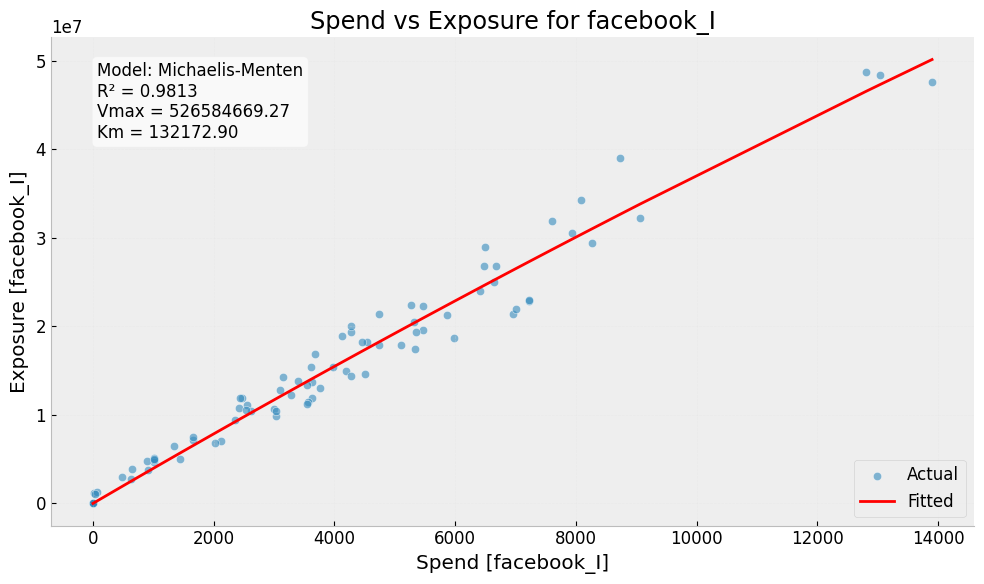

2024-11-21 02:18:26,739 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: search_clicks_P
2024-11-21 02:18:26,893 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel search_clicks_P


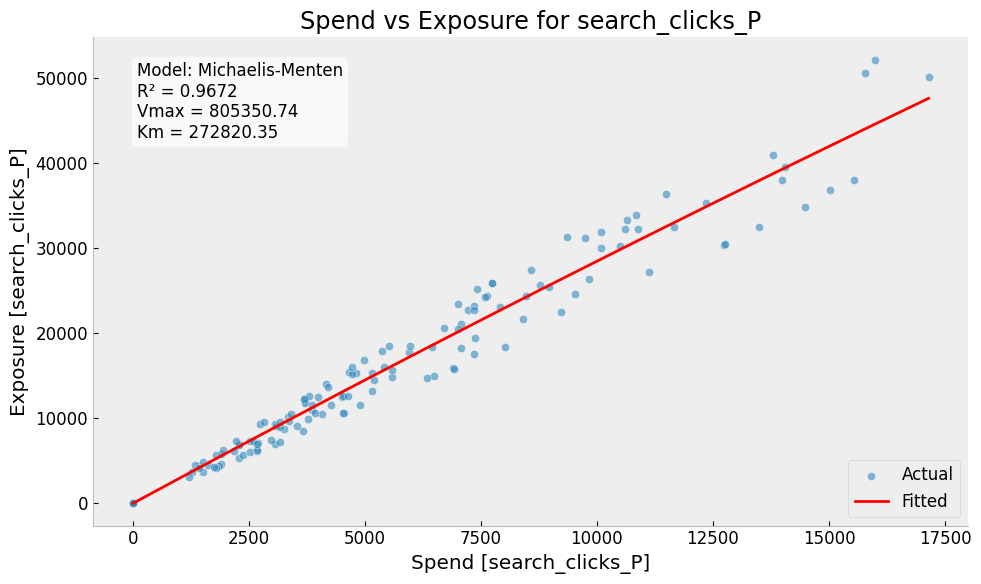

In [8]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt
%matplotlib inline

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters, featurized_mmm_data)
# Extract the list of results
results_list = featurized_mmm_data.modNLS["results"]
# Plot spend-exposure relationship for each channel in the results
for result in results_list:
    channel = result["channel"]
    try:
        fig = feature_plotter.plot_spend_exposure(channel)
        plt.show()
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")

2024-11-21 02:18:26,989 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2024-11-21 02:18:26,989 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2024-11-21 02:18:26,990 - robyn.modeling.base_model_executor - INFO - Input validation successful
2024-11-21 02:18:26,991 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2024-11-21 02:18:26,991 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2024-11-21 02:18:26,992 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2024-11-21 02:18:26,992 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2024-11-21 02:18:26,992 - robyn.modeling.ridge_model_builder - INFO - Collecting hyperparameters for optimization...


>>> Starting 5 trials with 54 iterations each using TwoPointsDE nevergrad algorithm on...


Running trial 1 of total 5 trials:   2%|▋                                  

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     44542.944419
2     31735.192527
3    106060.451951
4     75564.130437
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     44542.944419
2     31735.192527
3    106060.451951
4     75564.130437
Name: tv_S, dtype: float64
After hill: 0    0.140532
1    0.256981
2    0.193572
3    0.464101
4    0.377434
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     26382.875082
4    282598.054104
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     26382.875082
4    282598.054104
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.292209
3    0.071766
4    0.476043
Name: ooh_S, dty

Running trial 1 of total 5 trials:   4%|█▎                                 

Model coefficients:
[ 0.00911699  0.00645789  0.14681872  0.02647971  0.14551414 -0.00320654
  0.12574535  0.02760951  0.03700401  0.07914851  0.06617967  0.05462481]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46112.091562
2     36089.377281
3    111695.461210
4     87417.844292
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46112.091562
2     36089.377281
3    111695.461210
4     87417.844292
Name: tv_S, dtype: float64
After hill: 0    0.054832
1    0.158106
2    0.113708
3    0.408369
4    0.326680
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     18069.239422
4    279804.259469
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 1 of total 5 trials:   6%|█▉                                 

After adstock: 0    12728.488889
1     3722.289937
2     1542.404552
3    18131.057230
4     5302.204564
Name: print_S, dtype: float64
Before hill: 0    12728.488889
1     3722.289937
2     1542.404552
3    18131.057230
4     5302.204564
Name: print_S, dtype: float64
After hill: 0    0.365529
1    0.088248
2    0.026253
3    0.490457
4    0.139200
Name: print_S, dtype: float64
Before adstock: 0    7607.132915
1    1141.952450
2    4256.375378
3    2800.490677
4     689.582605
Name: facebook_S, dtype: float64
After adstock: 0    7607.132915
1    2132.170664
2    4533.919395
3    3390.669607
4    1130.945053
Name: facebook_S, dtype: float64
Before hill: 0    7607.132915
1    2132.170664
2    4533.919395
3    3390.669607
4    1130.945053
Name: facebook_S, dtype: float64
After hill: 0    0.416461
1    0.230268
2    0.333794
3    0.291173
4    0.162431
Name: facebook_S, dtype: float64
Before adstock: 0       0.000000
1    4133.333333
2    3786.666667
3    4253.333333
4    3613.333333
Name: 

Running trial 1 of total 5 trials:   7%|██▌                                

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38326.466222
2    16649.954755
3    90683.454428
4    39395.111580
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38326.466222
2    16649.954755
3    90683.454428
4    39395.111580
Name: tv_S, dtype: float64
After hill: 0    0.118245
1    0.329964
2    0.061754
3    0.797354
4    0.344799
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     42900.330443
4    291249.370226
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     42900.330443
4    291249.370226
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.380388
3    0.041979
4    0.796153
Name: ooh_S, dtype: float6

Running trial 1 of total 5 trials:  11%|███▉                               

After adstock: 0    7607.132915
1    2211.333183
2    4567.235872
3    3442.534677
4    1173.520548
Name: facebook_S, dtype: float64
Before hill: 0    7607.132915
1    2211.333183
2    4567.235872
3    3442.534677
4    1173.520548
Name: facebook_S, dtype: float64
After hill: 0    0.400073
1    0.023376
2    0.144416
3    0.073073
4    0.004327
Name: facebook_S, dtype: float64
Before adstock: 0       0.000000
1    4133.333333
2    3786.666667
3    4253.333333
4    3613.333333
Name: search_S, dtype: float64
After adstock: 0       0.000000
1    4133.333333
2    4430.878587
3    4943.919980
4    4383.881443
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4430.878587
3    4943.919980
4    4383.881443
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.048502
2    0.056827
3    0.072712
4    0.055468
Name: search_S, dtype: float64
Model coefficients:
[-0.004602    0.00659424  0.12320796  0.02796219  0.12157014  0.01943237
  0.0887357   0.0317261

Running trial 1 of total 5 trials:  15%|█████▏                             


Before adstock: 0       0.000000
1    4133.333333
2    3786.666667
3    4253.333333
4    3613.333333
Name: search_S, dtype: float64
After adstock: 0       0.000000
1    4133.333333
2    4456.659272
3    4975.735451
4    4419.875097
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4456.659272
3    4975.735451
4    4419.875097
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.312838
2    0.321016
3    0.333179
4    0.320111
Name: search_S, dtype: float64
Model coefficients:
[ 0.00664294  0.00952033  0.2047202   0.03946596  0.20436386 -0.01635804
  0.1717799   0.03875507  0.05220774  0.11392162  0.06953962  0.07670918]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35557.422967
2    11043.288174
3    86880.088792
4    26982.885065
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35557.422967
2    11043.28

Running trial 1 of total 5 trials:  17%|█████▊                             

Model coefficients:
[0.0110188  0.00681424 0.15837326 0.02814915 0.15716084 0.00756368
 0.1406822  0.0307886  0.04472409 0.06764248 0.07160175 0.05942036]


Running trial 1 of total 5 trials:  19%|██████▍                            

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40471.040995
2    21463.524271
3    94833.331733
4    50294.172507
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40471.040995
2    21463.524271
3    94833.331733
4    50294.172507
Name: tv_S, dtype: float64
After hill: 0    0.020258
1    0.068626
2    0.018591
3    0.312845
4    0.104983
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     51559.887034
4    297433.173469
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     51559.887034
4    297433.173469
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.206194
3    0.069205
4    0.432372
Name: ooh_S, dtype: float6

Running trial 1 of total 5 trials:  20%|███████▏                           

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45577.403857
2     34580.948025
3    109687.912697
4     83223.520582
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45577.403857
2     34580.948025
3    109687.912697
4     83223.520582
Name: tv_S, dtype: float64
After hill: 0    0.005639
1    0.041145
2    0.019568
3    0.309489
4    0.178024
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     14346.534208
4    278891.983772
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     14346.534208
4    278891.983772
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.293537
3    0.039613
4    0.474365
Name: ooh_S, dty

Running trial 1 of total 5 trials:  24%|████████▍                          

After adstock: 0       0.000000
1    4133.333333
2    3844.156176
3    4306.800749
4    3673.235558
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    3844.156176
3    4306.800749
4    3673.235558
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.255820
2    0.245098
3    0.262031
4    0.238532
Name: search_S, dtype: float64
Model coefficients:
[ 0.00591199  0.00847276  0.1821939   0.03512334  0.18187677 -0.04298884
  0.15074184  0.03110094  0.04912865  0.10047998  0.06307748  0.06826852]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     44907.872023
2     32728.165465
3    107302.089582
4     78200.110232
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     44907.872023
2     32728.165465
3    107302.089582
4     78200.110232
Name: tv_S, dtype: float64
After hill: 0    0.015033
1    0.086863
2    0.040226
3

Running trial 1 of total 5 trials:  28%|█████████▋                         


Before hill: 0       0.000000
1    4133.333333
2    3920.878263
3    4380.646398
4    3755.575321
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.380068
2    0.369054
3    0.392341
4    0.360163
Name: search_S, dtype: float64
Model coefficients:
[-0.00142091  0.00540341  0.08196838  0.01853256  0.08082234  0.00037379
  0.07035353  0.0147345   0.02915975  0.04953103  0.02468859  0.02763231]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38980.877781
2    18075.187372
3    91831.657142
4    42581.760698
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38980.877781
2    18075.187372
3    91831.657142
4    42581.760698
Name: tv_S, dtype: float64
After hill: 0    0.019529
1    0.085756
2    0.010888
3    0.505253
4    0.107134
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0


Running trial 1 of total 5 trials:  31%|███████████                        


[-0.00706471  0.00561422  0.13149697  0.02978058  0.12995798  0.01591255
  0.07139905  0.02177602  0.0500832   0.07129101  0.04716941  0.04642431]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46377.015165
2     36846.238621
3    112724.404961
4     89558.810735
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46377.015165
2     36846.238621
3    112724.404961
4     89558.810735
Name: tv_S, dtype: float64
After hill: 0    0.000356
1    0.005132
2    0.002323
3    0.083430
4    0.042328
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     34585.664594
4    286378.808164
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     34585.6645

Running trial 1 of total 5 trials:  37%|████████████▉                      

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     42823.038691
2     27215.680687
3    100746.913771
4     64028.521075
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     42823.038691
2     27215.680687
3    100746.913771
4     64028.521075
Name: tv_S, dtype: float64
After hill: 0    0.215646
1    0.318235
2    0.244059
3    0.482441
4    0.392645
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     24610.646256
4    281914.857237
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     24610.646256
4    281914.857237
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.396826
3    0.038698
4    0.698120
Name: ooh_S, dty

Running trial 1 of total 5 trials:  39%|█████████████▌                     

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37870.997357
2    15680.606017
3    89942.911093
4    37241.146294
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37870.997357
2    15680.606017
3    89942.911093
4    37241.146294
Name: tv_S, dtype: float64
After hill: 0    0.020547
1    0.060080
2    0.009810
3    0.284626
4    0.058109
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     34992.081503
4    286592.581331
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     34992.081503
4    286592.581331
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.404467
3    0.214030
4    0.536056
Name: ooh_S, dtype: float6

Running trial 1 of total 5 trials:  43%|██████████████▉                    

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40984.594906
2    22677.268289
3    95997.911400
4    53116.796617
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40984.594906
2    22677.268289
3    95997.911400
4    53116.796617
Name: tv_S, dtype: float64
After hill: 0    0.029812
1    0.091299
2    0.030625
3    0.345868
4    0.142868
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     25002.388940
4    282061.786317
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     25002.388940
4    282061.786317
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.192105
3    0.006293
4    0.552701
Name: ooh_S, dtype: float6

Running trial 1 of total 5 trials:  46%|████████████████▏                  

Model coefficients:
[0.0118043  0.01898371 0.09751891 0.01700252 0.09687771 0.00277271
 0.08129155 0.0218223  0.03629832 0.05487704 0.04157398 0.03785667]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36568.510568
2    13011.006534
3    88079.598054
4    31338.553525
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36568.510568
2    13011.006534
3    88079.598054
4    31338.553525
Name: tv_S, dtype: float64
After hill: 0    0.181553
1    0.260963
2    0.117379
3    0.447602
4    0.233831
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     32859.279959
4    285498.574384
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     32859.279959


Running trial 1 of total 5 trials:  52%|██████████████████▏                

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46084.220131
2     36010.116266
3    111588.538577
4     87195.058019
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46084.220131
2     36010.116266
3    111588.538577
4     87195.058019
Name: tv_S, dtype: float64
After hill: 0    0.001881
1    0.018860
2    0.008912
3    0.202440
4    0.111530
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     41793.097641
4    290540.446156
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     41793.097641
4    290540.446156
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.085381
3    0.003490
4    0.467677
Name: ooh_S, dty

Running trial 1 of total 5 trials:  56%|███████████████████▍               

After adstock: 0       0.000000
1    4133.333333
2    4718.564204
3    5317.176485
4    4812.139060
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4718.564204
3    5317.176485
4    4812.139060
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.135541
2    0.181289
3    0.232137
4    0.189011
Name: search_S, dtype: float64
Model coefficients:
[ 0.00178005  0.00208096  0.07086324  0.01008346  0.07110922 -0.00861851
  0.04708497  0.01858053  0.02526973  0.02621955  0.02894061  0.01837833]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45009.184085
2     33005.949618
3    107654.093790
4     78944.456960
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45009.184085
2     33005.949618
3    107654.093790
4     78944.456960
Name: tv_S, dtype: float64
After hill: 0    0.033829
1    0.098252
2    0.062207
3

Running trial 1 of total 5 trials:  59%|████████████████████▋              

Model coefficients:
[0.007119   0.01539579 0.11918511 0.02563797 0.11831833 0.0080114
 0.08825861 0.02638346 0.04337679 0.07949404 0.0569153  0.04337785]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    42090.829766
2    25371.909900
3    98744.227351
4    59521.982660
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    42090.829766
2    25371.909900
3    98744.227351
4    59521.982660
Name: tv_S, dtype: float64
After hill: 0    0.131650
1    0.252759
2    0.151140
3    0.498235
4    0.343920
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     37674.485787
4    288066.148530
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     37674.485787
4

Running trial 1 of total 5 trials:  63%|██████████████████████             

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45376.034116
2     34019.484930
3    108955.518337
4     81686.526517
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45376.034116
2     34019.484930
3    108955.518337
4     81686.526517
Name: tv_S, dtype: float64
After hill: 0    0.089621
1    0.172359
2    0.133791
3    0.334277
4    0.273902
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     44970.212887
4    292624.361872
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     44970.212887
4    292624.361872
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.191663
3    0.029132
4    0.520481
Name: ooh_S, dty

Running trial 1 of total 5 trials:  69%|███████████████████████▉           

Model coefficients:
[ 0.01512619  0.01681984  0.36658724  0.06910125  0.36496809 -0.00997744
  0.31542579  0.07519437  0.11250507  0.17786829  0.12885505  0.13565149]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    42175.275591
2    25582.105858
3    98967.552990
4    60030.394149
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    42175.275591
2    25582.105858
3    98967.552990
4    60030.394149
Name: tv_S, dtype: float64
After hill: 0    0.030557
1    0.114630
2    0.040833
3    0.461501
4    0.220765
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     26491.609851
4    282641.517700
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     2

Running trial 1 of total 5 trials:  74%|█████████████████████████▉         

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35569.478781
2    11066.211793
3    86893.175318
4    27033.802980
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35569.478781
2    11066.211793
3    86893.175318
4    27033.802980
Name: tv_S, dtype: float64
After hill: 0    0.390952
1    0.457343
2    0.298226
3    0.587282
4    0.417764
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     34132.479358
4    286143.380095
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     34132.479358
4    286143.380095
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.230418
3    0.078950
4    0.379058
Name: ooh_S, dtype: float6

Running trial 1 of total 5 trials:  80%|███████████████████████████▊       

Model coefficients:
[-0.00767462  0.00642763  0.14343227  0.03273841  0.14151031 -0.00519817
  0.0925389   0.03566315  0.0497458   0.07549241  0.05188283  0.04752153]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37481.617823
2    14866.624851
3    89346.971413
4    35438.382406
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37481.617823
2    14866.624851
3    89346.971413
4    35438.382406
Name: tv_S, dtype: float64
After hill: 0    0.238094
1    0.353268
2    0.167379
3    0.582768
4    0.339552
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     26579.062560
4    282676.604109
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     2

Running trial 1 of total 5 trials:  83%|█████████████████████████████▏     

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    41441.564124
2    23777.114823
3    97092.436283
4    55706.826099
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    41441.564124
2    23777.114823
3    97092.436283
4    55706.826099
Name: tv_S, dtype: float64
After hill: 0    0.263420
1    0.353022
2    0.271687
3    0.493876
4    0.400434
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     20163.042675
4    280409.429146
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     20163.042675
4    280409.429146
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.224031
3    0.002688
4    0.651270
Name: ooh_S, dtype: float6

Running trial 1 of total 5 trials:  87%|██████████████████████████████▍    

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     43653.934768
2     29366.044155
3    103204.872982
4     69426.017908
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     43653.934768
2     29366.044155
3    103204.872982
4     69426.017908
Name: tv_S, dtype: float64
After hill: 0    0.305530
1    0.402150
2    0.343625
3    0.535444
4    0.473665
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     33569.209615
4    285855.091811
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     33569.209615
4    285855.091811
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.134978
3    0.006340
4    0.484693
Name: ooh_S, dty

Running trial 1 of total 5 trials:  91%|███████████████████████████████▊   

Model coefficients:
[0.00436773 0.00698254 0.06368097 0.00753042 0.06517877 0.0104834
 0.04418768 0.01730657 0.02350844 0.02870097 0.01892853 0.01719545]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35349.924161
2    10650.775589
3    86659.338181
4    26110.074789
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35349.924161
2    10650.775589
3    86659.338181
4    26110.074789
Name: tv_S, dtype: float64
After hill: 0    0.005922
1    0.019442
2    0.000850
3    0.172664
4    0.008872
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     18888.959758
4    280033.286940
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     18888.959758
4

Running trial 1 of total 5 trials:  94%|█████████████████████████████████  

Model coefficients:
[-0.00375484  0.01427881  0.2166062   0.04897338  0.21357772  0.0086215
  0.14594436  0.04618812  0.07661176  0.11745193  0.07830637  0.07301997]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     42589.913498
2     26623.445744
3    100092.929416
4     62569.243673
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     42589.913498
2     26623.445744
3    100092.929416
4     62569.243673
Name: tv_S, dtype: float64
After hill: 0    0.272581
1    0.365407
2    0.296332
3    0.503516
4    0.426336
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     41743.498577
4    290509.123303
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.40000

Running trial 1 of total 5 trials:  96%|█████████████████████████████████▋ 

Model coefficients:
[0.02650976 0.04258344 0.21736699 0.03783476 0.21598646 0.01632571
 0.1870386  0.03010655 0.07595089 0.14130444 0.09700166 0.08483035]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46386.475242
2     36873.381249
3    112761.571160
4     89636.049774
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46386.475242
2     36873.381249
3    112761.571160
4     89636.049774
Name: tv_S, dtype: float64
After hill: 0    0.078986
1    0.169401
2    0.136219
3    0.340673
4    0.290363
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     14959.454516
4    279027.774919
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     149

Running trial 1 of total 5 trials: 100%|███████████████████████████████████
2024-11-21 02:18:33,665 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.11 mins


Model coefficients:
[ 0.00451958  0.01469304  0.1418158   0.02819615  0.1410728  -0.02978442
  0.12705957  0.02278709  0.06097516  0.08981438  0.04988942  0.05241057]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37677.723944
2    15274.881051
3    89642.877945
4    36342.012053
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37677.723944
2    15274.881051
3    89642.877945
4    36342.012053
Name: tv_S, dtype: float64
After hill: 0    0.010047
1    0.035322
2    0.003961
3    0.235659
4    0.032420
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     36860.150215
4    287607.296552
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     3

Running trial 2 of total 5 trials:   0%|                                   

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    41546.385932
2    24032.036759
3    97351.366358
4    56311.796139
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    41546.385932
2    24032.036759
3    97351.366358
4    56311.796139
Name: tv_S, dtype: float64
After hill: 0    0.239010
1    0.345893
2    0.250244
3    0.519161
4    0.405640
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     36255.441499
4    287273.049725
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     36255.441499
4    287273.049725
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.131226
3    0.011280
4    0.415232
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:   4%|█▎                                 

After hill: 0    0.213481
1    0.026784
2    0.089325
3    0.054613
4    0.006974
Name: facebook_S, dtype: float64
Before adstock: 0       0.000000
1    4133.333333
2    3786.666667
3    4253.333333
4    3613.333333
Name: search_S, dtype: float64
After adstock: 0       0.000000
1    4133.333333
2    4051.447563
3    4512.868636
4    3902.427221
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4051.447563
3    4512.868636
4    3902.427221
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.204725
2    0.200522
3    0.223947
4    0.192825
Name: search_S, dtype: float64
Model coefficients:
[0.01155798 0.01862933 0.09836327 0.01729332 0.09779513 0.00590073
 0.08309867 0.01788888 0.03166658 0.0450496  0.04394755 0.03840189]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46260.989982
2     36513.993108
3    112270.954327
4

Running trial 2 of total 5 trials:   7%|██▌                                

Model coefficients:
[-0.1591609   0.22805697  4.26111883  0.96708127  4.20447614  0.43708333
  2.43743854  0.68191077  1.45545266  2.25220497  1.53846556  1.41382343]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40705.865831
2    22015.586754
3    95357.338988
4    51573.593296
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40705.865831
2    22015.586754
3    95357.338988
4    51573.593296
Name: tv_S, dtype: float64
After hill: 0    0.004374
1    0.023180
2    0.004188
3    0.206125
4    0.044127
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45887.704833
4    293254.558547
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 2 of total 5 trials:   9%|███▏                               

Model coefficients:
[ 0.02470509  0.04015707  0.21375532  0.03752349  0.2124486  -0.01262632
  0.12689728  0.05682725  0.07158171  0.08730844  0.09520409  0.08318708]


Running trial 2 of total 5 trials:  11%|███▉                               

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40766.294139
2    22158.448937
3    95494.493406
4    51905.867349
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40766.294139
2    22158.448937
3    95494.493406
4    51905.867349
Name: tv_S, dtype: float64
After hill: 0    0.018486
1    0.071982
2    0.018105
3    0.364909
4    0.120466
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     36724.279184
4    287531.713598
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     36724.279184
4    287531.713598
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.290818
3    0.041932
4    0.614017
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:  13%|████▌                              

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37229.296486
2    14346.399758
3    88978.726632
4    34288.168262
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37229.296486
2    14346.399758
3    88978.726632
4    34288.168262
Name: tv_S, dtype: float64
After hill: 0    0.092882
1    0.191829
2    0.046947
3    0.499598
4    0.171667
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     27269.262411
4    282957.572928
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     27269.262411
4    282957.572928
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.084721
3    0.001065
4    0.442679
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:  17%|█████▊                             

Before hill: 0    7607.132915
1    1751.319467
2    4396.664279
3    3152.684102
4     942.127385
Name: facebook_S, dtype: float64
After hill: 0    0.385115
1    0.010084
2    0.118645
3    0.050306
4    0.001787
Name: facebook_S, dtype: float64
Before adstock: 0       0.000000
1    4133.333333
2    3786.666667
3    4253.333333
4    3613.333333
Name: search_S, dtype: float64
After adstock: 0       0.000000
1    4133.333333
2    4984.412647
3    5697.702740
4    5264.397984
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4984.412647
3    5697.702740
4    5264.397984
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.046958
2    0.072321
3    0.097634
4    0.081838
Name: search_S, dtype: float64
Model coefficients:
[ 0.00180469  0.00210977  0.0718443   0.01022306  0.07209368 -0.00098578
  0.04888319  0.01542434  0.02578254  0.03067646  0.02162555  0.01863276]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.3

Running trial 2 of total 5 trials:  20%|███████▏                           

Model coefficients:
[-0.00602425  0.00397123  0.09674025  0.02219903  0.09561457 -0.00459162
  0.05201037  0.0263089   0.03209278  0.04139644  0.03445368  0.03293831]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38587.236035
2    17213.290098
3    91128.943087
4    40651.497615
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38587.236035
2    17213.290098
3    91128.943087
4    40651.497615
Name: tv_S, dtype: float64
After hill: 0    0.096353
1    0.282973
2    0.053874
3    0.755903
4    0.308997
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     30336.457736
4    284293.301177
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     3

Running trial 2 of total 5 trials:  24%|████████▍                          

Model coefficients:
[0.00035138 0.00623838 0.07636179 0.01732036 0.07578874 0.00598728
 0.06502878 0.02088457 0.03014079 0.04500606 0.02952746 0.02635825]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    41379.399905
2    23626.398510
3    96940.272877
4    55349.993569
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    41379.399905
2    23626.398510
3    96940.272877
4    55349.993569
Name: tv_S, dtype: float64
After hill: 0    0.267040
1    0.365495
2    0.275165
3    0.520054
4    0.416895
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     17263.847825
4    279589.130078
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     17263.847825


Running trial 2 of total 5 trials:  28%|█████████▋                         

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37207.945781
2    14302.641146
3    88948.206093
4    34191.467593
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37207.945781
2    14302.641146
3    88948.206093
4    34191.467593
Name: tv_S, dtype: float64
After hill: 0    0.050439
1    0.156566
2    0.017414
3    0.612269
4    0.131051
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     17754.210225
4    279718.943706
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     17754.210225
4    279718.943706
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.294543
3    0.076287
4    0.433114
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:  30%|██████████▎                        

After adstock: 0       0.000000
1    4133.333333
2    4038.266707
3    4499.146575
4    3887.200783
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4038.266707
3    4499.146575
4    3887.200783
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.374414
2    0.369287
3    0.393332
4    0.360950
Name: search_S, dtype: float64
Model coefficients:
[0.00756729 0.01084505 0.23320651 0.04495755 0.23280058 0.01921288
 0.16297098 0.02784514 0.06431351 0.09382132 0.08313064 0.08738307]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    42512.742611
2    26428.470600
3    99879.829096
4    62091.292273
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    42512.742611
2    26428.470600
3    99879.829096
4    62091.292273
Name: tv_S, dtype: float64
After hill: 0    0.006055
1    0.037555
2    0.009795
3    0.312171
4    0.10

Running trial 2 of total 5 trials:  35%|████████████▎                      

Model coefficients:
[0.0296752  0.04783097 0.25254862 0.04440078 0.25108993 0.0152571
 0.17695405 0.06441424 0.08782616 0.14608734 0.10361914 0.0985972 ]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37805.298750
2    15542.314789
3    89839.981051
4    36934.538604
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37805.298750
2    15542.314789
3    89839.981051
4    36934.538604
Name: tv_S, dtype: float64
After hill: 0    0.005600
1    0.026250
2    0.001901
3    0.262425
4    0.024531
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     29710.290583
4    284009.057480
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     29710.290583
4

Running trial 2 of total 5 trials:  41%|██████████████▎                    

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36142.805164
2    12171.378336
3    87549.115542
4    29482.863972
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36142.805164
2    12171.378336
3    87549.115542
4    29482.863972
Name: tv_S, dtype: float64
After hill: 0    0.354679
1    0.435619
2    0.263373
3    0.590625
4    0.400601
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     40252.939306
4    289585.158765
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     40252.939306
4    289585.158765
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.196659
3    0.044263
4    0.422933
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:  44%|███████████████▌                   

After adstock: 0       0.000000
1    4133.333333
2    4052.782525
3    4514.263099
4    3903.974543
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4052.782525
3    4514.263099
4    3903.974543
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.043872
2    0.041649
3    0.055294
4    0.037716
Name: search_S, dtype: float64
Model coefficients:
[ 0.01967119  0.06395059  0.61724651  0.12272264  0.61401269 -0.06028844
  0.50558838  0.14137466  0.20979983  0.31154639  0.21324205  0.22811443]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37230.291594
2    14348.440242
3    88980.151547
4    34292.677616
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37230.291594
2    14348.440242
3    88980.151547
4    34292.677616
Name: tv_S, dtype: float64
After hill: 0    0.199063
1    0.297636
2    0.135128
3    0.5132

Running trial 2 of total 5 trials:  48%|████████████████▊                  

Before adstock: 0       0.000000
1    4133.333333
2    3786.666667
3    4253.333333
4    3613.333333
Name: search_S, dtype: float64
After adstock: 0       0.000000
1    4133.333333
2    4132.756626
3    4599.375004
4    3998.445634
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4132.756626
3    4599.375004
4    3998.445634
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.101136
2    0.101099
3    0.132770
4    0.092766
Name: search_S, dtype: float64
Model coefficients:
[ 0.00771747  0.01375659  0.08744517  0.01878149  0.08666455 -0.00343149
  0.06172573  0.0210295   0.02900873  0.04598088  0.03849589  0.03216216]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45859.967176
2     35374.912578
3    110737.383325
4     85419.277323
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45859.967176
2     3

Running trial 2 of total 5 trials:  52%|██████████████████▏                

Model coefficients:
[ 0.01570234  0.02522315  0.12875141  0.02241038  0.12793369 -0.00419267
  0.11420975  0.03387105  0.04640221  0.08703363  0.06047495  0.05024695]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     43057.413915
2     27815.991881
3    101420.020451
4     65519.458995
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     43057.413915
2     27815.991881
3    101420.020451
4     65519.458995
Name: tv_S, dtype: float64
After hill: 0    0.012245
1    0.045365
2    0.019063
3    0.213250
4    0.100478
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     47287.519436
4    294240.570167
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 2 of total 5 trials:  56%|███████████████████▍               

Model coefficients:
[ 0.01037802  0.01672746  0.08832135  0.01552784  0.08781122 -0.00753754
  0.05904712  0.02312982  0.02667227  0.05328783  0.03146825  0.03448144]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     43880.614938
2     29963.415880
3    103910.509708
4     70954.197454
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     43880.614938
2     29963.415880
3    103910.509708
4     70954.197454
Name: tv_S, dtype: float64
After hill: 0    0.262219
1    0.371374
2    0.307355
3    0.528175
4    0.457829
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     29810.154508
4    284053.992596
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 2 of total 5 trials:  59%|████████████████████▋              

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35339.997425
2    10632.094333
3    86648.989127
4    26068.485947
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35339.997425
2    10632.094333
3    86648.989127
4    26068.485947
Name: tv_S, dtype: float64
After hill: 0    0.077735
1    0.150238
2    0.024691
3    0.430074
4    0.097519
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     37282.156477
4    287843.831903
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     37282.156477
4    287843.831903
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.378916
3    0.233369
4    0.483178
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:  67%|███████████████████████▎           

Model coefficients:
[ 0.00789053  0.01269174  0.06523456  0.01137525  0.06480782 -0.01204745
  0.04391635  0.01099217  0.0259004   0.04452933  0.02340896  0.02532082]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    41701.274562
2    24410.518123
3    97739.399776
4    57213.344546
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    41701.274562
2    24410.518123
3    97739.399776
4    57213.344546
Name: tv_S, dtype: float64
After hill: 0    0.172799
1    0.256876
2    0.183197
3    0.407011
4    0.308451
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     44653.382606
4    292409.697430
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 2 of total 5 trials:  70%|████████████████████████▋          

After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     16162.535595
4    279310.831544
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     16162.535595
4    279310.831544
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.333892
3    0.105418
4    0.456141
Name: ooh_S, dtype: float64
Before adstock: 0    12728.488889
1        0.000000
2      453.866667
3    17680.000000
4        0.000000
Name: print_S, dtype: float64
After adstock: 0    12728.488889
1     4912.754693
2     2350.019375
3    18587.025870
4     7173.946521
Name: print_S, dtype: float64
Before hill: 0    12728.488889
1     4912.754693
2     2350.019375
3    18587.025870
4     7173.946521
Name: print_S, dtype: float64
After hill: 0    0.260087
1    0.055710
2    0.014589
3    0.416853
4    0.107124
Name: print_S, dtype: float64
Before adstock: 0    7607.132915
1    1141.952450
2    4256.375378
3    2800.490677
4     689.582605

Running trial 2 of total 5 trials:  74%|█████████████████████████▉         

Model coefficients:
[0.00638849 0.01120021 0.06984319 0.01236351 0.06932037 0.0007308
 0.03805723 0.01835935 0.02376027 0.03049269 0.03328903 0.02678233]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40653.111810
2    21891.134864
3    95238.378091
4    51284.540990
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40653.111810
2    21891.134864
3    95238.378091
4    51284.540990
Name: tv_S, dtype: float64
After hill: 0    0.091998
1    0.201737
2    0.089333
3    0.480998
4    0.264892
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     43426.867415
4    291592.997465
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     43426.867415
4

Running trial 2 of total 5 trials:  78%|███████████████████████████▏       

After hill: 0    0.561746
1    0.307780
2    0.446636
3    0.387368
4    0.195029
Name: facebook_S, dtype: float64
Before adstock: 0       0.000000
1    4133.333333
2    3786.666667
3    4253.333333
4    3613.333333
Name: search_S, dtype: float64
After adstock: 0       0.000000
1    4133.333333
2    4481.222731
3    5006.347952
4    4454.588816
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4481.222731
3    5006.347952
4    4454.588816
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.012287
2    0.015443
3    0.021100
4    0.015185
Name: search_S, dtype: float64
Model coefficients:
[ 0.00633108  0.01020454  0.05388019  0.00947271  0.05356898 -0.00356889
  0.04826421  0.01392543  0.01775983  0.03721316  0.01535466  0.0210353 ]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40600.068534
2    21766.251589
3    95119.

Running trial 2 of total 5 trials:  81%|████████████████████████████▌      

Model coefficients:
[ 0.01141785  0.02001761  0.1248275   0.02209674  0.12389309 -0.01328679
  0.10144426  0.01794612  0.04022557  0.08824644  0.04600884  0.04786682]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40406.524518
2    21312.712745
3    94691.850699
4    49945.899513
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40406.524518
2    21312.712745
3    94691.850699
4    49945.899513
Name: tv_S, dtype: float64
After hill: 0    0.119890
1    0.300986
2    0.110396
3    0.692415
4    0.393938
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     17754.210225
4    279718.943706
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     1

Running trial 2 of total 5 trials:  87%|██████████████████████████████▍    

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35774.340658
2    11457.735510
3    87119.967675
4    27902.612010
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35774.340658
2    11457.735510
3    87119.967675
4    27902.612010
Name: tv_S, dtype: float64
After hill: 0    0.151074
1    0.216724
2    0.086753
3    0.389562
4    0.179727
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     35929.484425
4    287095.173463
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     35929.484425
4    287095.173463
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.181119
3    0.029129
4    0.420414
Name: ooh_S, dtype: float6

Running trial 2 of total 5 trials:  91%|███████████████████████████████▊   

Model coefficients:
[0.00638294 0.00935268 0.1485951  0.01951968 0.14982727 0.00750606
 0.10733093 0.04471969 0.04810987 0.08673794 0.03543504 0.03785549]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37805.298750
2    15542.314789
3    89839.981051
4    36934.538604
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37805.298750
2    15542.314789
3    89839.981051
4    36934.538604
Name: tv_S, dtype: float64
After hill: 0    0.013508
1    0.047715
2    0.005546
3    0.298150
4    0.045167
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     43222.694536
4    291459.253101
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     43222.694536


Running trial 2 of total 5 trials:  96%|█████████████████████████████████▋ 

Model coefficients:
[-0.0372779   0.02663832  0.63027043  0.14444074  0.621175   -0.03050334
  0.45440624  0.12988044  0.22561227  0.36244218  0.12901191  0.20817471]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36142.805164
2    12171.378336
3    87549.115542
4    29482.863972
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36142.805164
2    12171.378336
3    87549.115542
4    29482.863972
Name: tv_S, dtype: float64
After hill: 0    0.252779
1    0.384868
2    0.134417
3    0.660104
4    0.325262
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     40252.939306
4    289585.158765
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 2 of total 5 trials: 100%|███████████████████████████████████
2024-11-21 02:18:39,755 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.10 mins


After adstock: 0       0.000000
1    4133.333333
2    4028.443376
3    4488.974572
4    3875.913052
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4028.443376
3    4488.974572
4    3875.913052
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.023120
2    0.021659
3    0.028494
4    0.019633
Name: search_S, dtype: float64
Model coefficients:
[ 0.01148378  0.02206957  0.15327915  0.03298584  0.1519588  -0.00309591
  0.12983864  0.04002084  0.0519223   0.10495167  0.04675911  0.05521008]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    41597.793588
2    24157.417086
3    97479.435376
4    56610.006796
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    41597.793588
2    24157.417086
3    97479.435376
4    56610.006796
Name: tv_S, dtype: float64
After hill: 0    0.255232
1    0.397127
2    0.271050
3    0.6168

Running trial 3 of total 5 trials:   0%|                                   

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     44024.239850
2     30344.290299
3    104365.510584
4     71935.310211
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     44024.239850
2     30344.290299
3    104365.510584
4     71935.310211
Name: tv_S, dtype: float64
After hill: 0    0.048045
1    0.112839
2    0.071289
3    0.287876
4    0.197438
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45469.246275
4    292965.553705
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     45469.246275
4    292965.553705
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.064656
3    0.005098
4    0.324232
Name: ooh_S, dty

Running trial 3 of total 5 trials:   4%|█▎                                 

After adstock: 0       0.000000
1    4133.333333
2    3790.629598
3    4256.967690
4    3617.414802
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    3790.629598
3    4256.967690
4    3617.414802
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.201804
2    0.177517
3    0.210621
4    0.165377
Name: search_S, dtype: float64
Model coefficients:
[-0.00657252  0.00505417  0.11661207  0.02665852  0.11507905 -0.00621489
  0.0994851   0.0222676   0.04381966  0.06285844  0.04347497  0.03915118]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37523.918489
2    14954.395922
3    89410.077565
4    35632.571255
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37523.918489
2    14954.395922
3    89410.077565
4    35632.571255
Name: tv_S, dtype: float64
After hill: 0    0.006640
1    0.029088
2    0.002080
3    0.2703

Running trial 3 of total 5 trials:   7%|██▌                                

Model coefficients:
[ 0.04120576  0.06824788  0.38178832  0.06748905  0.37917186 -0.01131329
  0.32073093  0.09826629  0.131143    0.26445296  0.15501751  0.14832346]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     44502.668300
2     31626.330592
3    105925.920489
4     75277.467794
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     44502.668300
2     31626.330592
3    105925.920489
4     75277.467794
Name: tv_S, dtype: float64
After hill: 0    0.127736
1    0.221837
2    0.170410
3    0.392350
4    0.319158
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     42666.670232
4    291098.222318
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 3 of total 5 trials:  11%|███▉                               

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     42639.446989
2     26748.874677
3    100230.596914
4     62877.355711
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     42639.446989
2     26748.874677
3    100230.596914
4     62877.355711
Name: tv_S, dtype: float64
After hill: 0    0.100550
1    0.187664
2    0.120371
3    0.375059
4    0.262927
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     23947.087310
4    281671.273111
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     23947.087310
4    281671.273111
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.063893
3    0.001118
4    0.295931
Name: ooh_S, dty

Running trial 3 of total 5 trials:  19%|██████▍                            

Model coefficients:
[0.00772839 0.0123551  0.11267889 0.01332454 0.11532914 0.00359373
 0.07678081 0.03553868 0.04443166 0.06899846 0.04120326 0.03042611]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45327.208921
2     33883.895918
3    108779.869857
4     81317.289902
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45327.208921
2     33883.895918
3    108779.869857
4     81317.289902
Name: tv_S, dtype: float64
After hill: 0    0.032994
1    0.099362
2    0.064265
3    0.305383
4    0.218209
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     22591.303459
4    281194.279144
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     225

Running trial 3 of total 5 trials:  22%|███████▊                           

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36476.383665
2    12827.928101
3    87961.601999
4    30934.127585
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36476.383665
2    12827.928101
3    87961.601999
4    30934.127585
Name: tv_S, dtype: float64
After hill: 0    0.152945
1    0.249171
2    0.082976
3    0.497869
4    0.212826
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     18762.867570
4    279997.395961
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     18762.867570
4    279997.395961
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.167650
3    0.001651
4    0.560056
Name: ooh_S, dtype: float6

Running trial 3 of total 5 trials:  26%|█████████                          

Model coefficients:
[ 0.01365753  0.01116982  0.24959778  0.04564286  0.24710198 -0.00760277
  0.15210795  0.02548409  0.07165435  0.10761316  0.10641488  0.08961945]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    42232.953175
2    25726.039034
3    99121.223205
4    60379.307284
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    42232.953175
2    25726.039034
3    99121.223205
4    60379.307284
Name: tv_S, dtype: float64
After hill: 0    0.005192
1    0.027932
2    0.007554
3    0.218788
4    0.069487
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45499.889241
4    292986.627169
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 3 of total 5 trials:  30%|██████████▎                        

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40673.971052
2    21940.314097
3    95285.329661
4    51398.720300
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40673.971052
2    21940.314097
3    95285.329661
4    51398.720300
Name: tv_S, dtype: float64
After hill: 0    0.032878
1    0.122085
2    0.031493
3    0.507008
4    0.194269
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45250.431802
4    292815.485527
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     45250.431802
4    292815.485527
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.027988
3    0.001295
4    0.222583
Name: ooh_S, dtype: float6

Running trial 3 of total 5 trials:  35%|████████████▎                      

Model coefficients:
[0.03511208 0.01420266 0.36653253 0.07610314 0.36265575 0.03282431
 0.32713197 0.03270791 0.09541767 0.11709176 0.18088083 0.15418226]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37828.926054
2    15592.004243
3    89876.886051
4    37044.688678
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37828.926054
2    15592.004243
3    89876.886051
4    37044.688678
Name: tv_S, dtype: float64
After hill: 0    0.203447
1    0.276500
2    0.162307
3    0.425843
4    0.273300
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     21636.100031
4    280874.906009
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     21636.100031


Running trial 3 of total 5 trials:  41%|██████████████▎                    

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40775.375620
2    22179.947243
3    95515.187792
4    51955.911967
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40775.375620
2    22179.947243
3    95515.187792
4    51955.911967
Name: tv_S, dtype: float64
After hill: 0    0.042921
1    0.132054
2    0.042256
3    0.461247
4    0.199271
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     43639.561577
4    291732.994026
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     43639.561577
4    291732.994026
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.309850
3    0.137567
4    0.484318
Name: ooh_S, dtype: float6

Running trial 3 of total 5 trials:  44%|███████████████▌                   

Model coefficients:
[-0.01453459  0.0131878   0.30268957  0.06795327  0.29937441  0.01099609
  0.1804184   0.08129389  0.09854788  0.05775721  0.08956158  0.10526581]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36055.072678
2    12000.356301
3    87444.434002
4    29104.486182
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36055.072678
2    12000.356301
3    87444.434002
4    29104.486182
Name: tv_S, dtype: float64
After hill: 0    0.082811
1    0.219707
2    0.020116
3    0.698741
4    0.144661
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     26977.544176
4    282837.940527
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     2

Running trial 3 of total 5 trials:  52%|██████████████████▏                

After adstock: 0       0.000000
1    4133.333333
2    4487.660097
3    5014.418876
4    4463.754629
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4487.660097
3    5014.418876
4    4463.754629
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.134326
2    0.146395
3    0.164090
4    0.145585
Name: search_S, dtype: float64
Model coefficients:
[ 0.86156193  1.6557443  11.50019643  2.47497032 11.4011429  -0.37450161
  8.34267107  3.07025676  3.93373932  6.92060368  4.81290794  4.14224851]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36776.556566
2    13427.237366
3    88352.633587
4    32257.826557
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36776.556566
2    13427.237366
3    88352.633587
4    32257.826557
Name: tv_S, dtype: float64
After hill: 0    0.236130
1    0.299799
2    0.181262
3    0.4317

Running trial 3 of total 5 trials:  56%|███████████████████▍               

After adstock: 0       0.000000
1    4133.333333
2    3933.749501
3    4393.314066
4    3769.667467
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    3933.749501
3    4393.314066
4    3769.667467
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.313741
2    0.304743
3    0.325027
4    0.297114
Name: search_S, dtype: float64
Model coefficients:
[0.03677106 0.03245262 0.7199359  0.13262779 0.7135899  0.05837
 0.48589959 0.09745216 0.19709008 0.37198517 0.24748294 0.25763998]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39448.917988
2    19118.021691
3    92715.421453
4    44932.422200
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39448.917988
2    19118.021691
3    92715.421453
4    44932.422200
Name: tv_S, dtype: float64
After hill: 0    0.048933
1    0.122389
2    0.037607
3    0.384551
4    0.14912

Running trial 3 of total 5 trials:  59%|████████████████████▋              

Model coefficients:
[0.00865973 0.01407603 0.07492637 0.01315288 0.07446834 0.00909711
 0.05483766 0.01925639 0.02452579 0.04075028 0.02565328 0.02915907]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37523.918489
2    14954.395922
3    89410.077565
4    35632.571255
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37523.918489
2    14954.395922
3    89410.077565
4    35632.571255
Name: tv_S, dtype: float64
After hill: 0    0.006640
1    0.029088
2    0.002080
3    0.270342
4    0.025143
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     48995.647346
4    295483.887023
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     48995.647346


Running trial 3 of total 5 trials:  63%|██████████████████████             

After adstock: 0       0.000000
1    4133.333333
2    4580.754584
3    5133.378947
4    4599.548059
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4580.754584
3    5133.378947
4    4599.548059
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.208686
2    0.227575
3    0.249879
4    0.228352
Name: search_S, dtype: float64
Model coefficients:
[ 0.00251616  0.00872126  0.08638844  0.01963217  0.08616613 -0.00170033
  0.06646631  0.01560673  0.02997829  0.05352284  0.03510138  0.03182464]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46184.767925
2     36296.381780
3    111975.454447
4     88000.958479
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46184.767925
2     36296.381780
3    111975.454447
4     88000.958479
Name: tv_S, dtype: float64
After hill: 0    0.049824
1    0.162755
2    0.113716
3

Running trial 3 of total 5 trials:  70%|████████████████████████▋          

Model coefficients:
[ 0.02133118  0.00678747  0.19015681  0.0384516   0.18936929 -0.00391437
  0.16330374  0.02097463  0.0573618   0.09895146  0.09931727  0.08780729]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36242.256874
2    12366.077944
3    87669.687492
4    29913.429305
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36242.256874
2    12366.077944
3    87669.687492
4    29913.429305
Name: tv_S, dtype: float64
After hill: 0    0.021136
1    0.058455
2    0.005879
3    0.299877
4    0.039207
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     24760.628107
4    281970.836105
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     2

Running trial 3 of total 5 trials:  74%|█████████████████████████▉         

After adstock: 0       0.000000
1    4133.333333
2    4009.897903
3    4469.898124
4    3854.741612
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4009.897903
3    4469.898124
4    3854.741612
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.147023
2    0.139289
3    0.168636
4    0.129737
Name: search_S, dtype: float64
Model coefficients:
[0.00318442 0.00497025 0.05522811 0.00681371 0.05634958 0.00252624
 0.04758394 0.0199375  0.01716153 0.03391065 0.01988786 0.01508976]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45243.176989
2     33651.036092
3    108479.323315
4     80684.909130
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45243.176989
2     33651.036092
3    108479.323315
4     80684.909130
Name: tv_S, dtype: float64
After hill: 0    0.003312
1    0.020712
2    0.009759
3    0.159082

Running trial 3 of total 5 trials:  78%|███████████████████████████▏       

Model coefficients:
[-0.00715975  0.00536984  0.12482818  0.0285641   0.12309287  0.01811767
  0.09670484  0.02094609  0.04421587  0.07081249  0.04273196  0.04116491]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45590.051270
2     34616.332855
3    109734.341603
4     83320.820853
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45590.051270
2     34616.332855
3    109734.341603
4     83320.820853
Name: tv_S, dtype: float64
After hill: 0    0.288868
1    0.386129
2    0.347864
3    0.510713
4    0.471613
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     31184.125544
4    284687.538014
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 3 of total 5 trials:  83%|█████████████████████████████▏     

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    42232.953175
2    25726.039034
3    99121.223205
4    60379.307284
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    42232.953175
2    25726.039034
3    99121.223205
4    60379.307284
Name: tv_S, dtype: float64
After hill: 0    0.005192
1    0.027932
2    0.007554
3    0.218788
4    0.069487
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     30345.892311
4    284297.629262
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     30345.892311
4    284297.629262
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.453957
3    0.175175
4    0.628205
Name: ooh_S, dtype: float6

Running trial 3 of total 5 trials:  85%|█████████████████████████████▊     

Model coefficients:
[0.00516886 0.00834294 0.0650378  0.00737588 0.06638622 0.00268378
 0.05337782 0.01024066 0.01989086 0.03901369 0.0242086  0.01847282]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35759.794211
2    11429.811110
3    87103.587814
4    27840.695891
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35759.794211
2    11429.811110
3    87103.587814
4    27840.695891
Name: tv_S, dtype: float64
After hill: 0    0.048668
1    0.099429
2    0.016758
3    0.321842
4    0.068266
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     34386.550593
4    286274.986726
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     34386.550593


Running trial 3 of total 5 trials:  91%|███████████████████████████████▊   

Model coefficients:
[ 0.01302724  0.02503581  0.17388051  0.03741927  0.17238271 -0.00535994
  0.10282586  0.05105136  0.05761335  0.07001934  0.05537285  0.06263055]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37828.926054
2    15592.004243
3    89876.886051
4    37044.688678
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37828.926054
2    15592.004243
3    89876.886051
4    37044.688678
Name: tv_S, dtype: float64
After hill: 0    0.203447
1    0.276500
2    0.162307
3    0.425843
4    0.273300
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     48710.070069
4    295272.949087
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 3 of total 5 trials:  96%|█████████████████████████████████▋ 

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38440.637056
2    16895.846925
3    90876.553087
4    39943.051094
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38440.637056
2    16895.846925
3    90876.553087
4    39943.051094
Name: tv_S, dtype: float64
After hill: 0    0.048724
1    0.133200
2    0.028203
3    0.467771
4    0.142432
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     43639.561577
4    291732.994026
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     43639.561577
4    291732.994026
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.309850
3    0.137567
4    0.484318
Name: ooh_S, dtype: float6

Running trial 3 of total 5 trials: 100%|███████████████████████████████████
2024-11-21 02:18:45,285 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.09 mins


After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     36524.830539
4    287421.268992
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     36524.830539
4    287421.268992
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.397001
3    0.176904
4    0.563923
Name: ooh_S, dtype: float64
Before adstock: 0    12728.488889
1        0.000000
2      453.866667
3    17680.000000
4        0.000000
Name: print_S, dtype: float64
After adstock: 0    12728.488889
1     2252.421245
2      852.452980
3    17830.849266
4     3155.330067
Name: print_S, dtype: float64
Before hill: 0    12728.488889
1     2252.421245
2      852.452980
3    17830.849266
4     3155.330067
Name: print_S, dtype: float64
After hill: 0    0.362940
1    0.032595
2    0.006848
3    0.496946
4    0.055199
Name: print_S, dtype: float64
Before adstock: 0    7607.132915
1    1141.952450
2    4256.375378
3    2800.490677
4     689.582605

Running trial 4 of total 5 trials:   0%|                                   

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64

Running trial 4 of total 5 trials:   4%|█▎                                 


After adstock: 0    22358.346667
1    35802.352378
2    11511.562131
3    87151.629454
4    28021.940757
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35802.352378
2    11511.562131
3    87151.629454
4    28021.940757
Name: tv_S, dtype: float64
After hill: 0    0.005713
1    0.022830
2    0.000794
3    0.248599
4    0.011134
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45246.750976
4    292812.967320
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     45246.750976
4    292812.967320
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.194918
3    0.010775
4    0.706588
Name: ooh_S, dtype: float64
Before adstock: 0    12728.488889
1        0.000000
2      453.866667
3    17680.000000
4        0.000000
Name: print_S, dtype: fl

Running trial 4 of total 5 trials:   6%|█▉                                 

Model coefficients:
[ 0.00981477  0.01578684  0.08114314  0.01414931  0.08061234 -0.00598432
  0.05663801  0.01708763  0.02734612  0.02296253  0.03902929  0.03149574]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38941.451727
2    17988.237543
3    91759.619123
4    42386.550896
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38941.451727
2    17988.237543
3    91759.619123
4    42386.550896
Name: tv_S, dtype: float64
After hill: 0    0.004529
1    0.022442
2    0.002406
3    0.218449
4    0.028557
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     37458.141799
4    287943.267604
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     3

Running trial 4 of total 5 trials:   7%|██▌                                

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46382.098819
2     36860.823524
3    112744.373677
4     89600.310623
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46382.098819
2     36860.823524
3    112744.373677
4     89600.310623
Name: tv_S, dtype: float64
After hill: 0    0.014493
1    0.068209
2    0.043452
3    0.290824
4    0.210081
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     32649.615428
4    285394.741167
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     32649.615428
4    285394.741167
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.151116
3    0.003883
4    0.592537
Name: ooh_S, dty

Running trial 4 of total 5 trials:   9%|███▏                               

Model coefficients:
[0.00897164 0.01448091 0.11288671 0.01280239 0.11522718 0.00643484
 0.09862194 0.02304862 0.03552521 0.07499813 0.04832561 0.03206344]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35435.458587
2    10812.109153
3    86749.310235
4    26469.052429
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35435.458587
2    10812.109153
3    86749.310235
4    26469.052429
Name: tv_S, dtype: float64
After hill: 0    0.021046
1    0.066990
2    0.003197
3    0.428128
4    0.032364
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     32250.363274
4    285198.855397
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     32250.363274


Running trial 4 of total 5 trials:  11%|███▉                               

Model coefficients:
[-0.01886296  0.01243459  0.30291033  0.06950902  0.29938564  0.02776391
  0.16115097  0.06775637  0.10596481  0.10783295  0.11290636  0.10313549]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     43521.160625
2     29018.278196
3    102798.606606
4     68542.256728
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     43521.160625
2     29018.278196
3    102798.606606
4     68542.256728
Name: tv_S, dtype: float64
After hill: 0    0.007088
1    0.034390
2    0.013255
3    0.216432
4    0.095335
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     48685.397129
4    295254.782610
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 4 of total 5 trials:  13%|████▌                              

Model coefficients:
[-0.00538843  0.00428211  0.10029616  0.02271442  0.09912233 -0.01282434
  0.07097894  0.02953297  0.03390557  0.05681291  0.03474915  0.03540903]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36357.314823
2    12592.434240
3    87811.723368
4    30413.779384
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36357.314823
2    12592.434240
3    87811.723368
4    30413.779384
Name: tv_S, dtype: float64
After hill: 0    0.012346
1    0.042156
2    0.002819
3    0.301435
4    0.026977
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     41237.518152
4    290191.711161
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 4 of total 5 trials:  15%|█████▏                             

Model coefficients:
[-0.00734776  0.01651611  0.2755853   0.06238903  0.27137158 -0.02355572
  0.14217643  0.0708824   0.10759717  0.1395354   0.11179657  0.09201639]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     43381.704213
2     28654.707836
3    102377.462620
4     67622.891575
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     43381.704213
2     28654.707836
3    102377.462620
4     67622.891575
Name: tv_S, dtype: float64
After hill: 0    0.250323
1    0.346384
2    0.284307
3    0.489170
4    0.418613
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     41575.843047
4    290403.520662
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 4 of total 5 trials:  17%|█████▊                             

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46448.678537
2     37052.052840
3    113006.682927
4     90145.289790
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46448.678537
2     37052.052840
3    113006.682927
4     90145.289790
Name: tv_S, dtype: float64
After hill: 0    0.003371
1    0.036798
2    0.018536
3    0.335065
4    0.210609
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     35319.137207
4    286766.424416
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     35319.137207
4    286766.424416
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.361917
3    0.188846
4    0.488686
Name: ooh_S, dty

Running trial 4 of total 5 trials:  19%|██████▍                            

Model coefficients:
[0.00840621 0.01392296 0.07788693 0.01376812 0.07735316 0.00518112
 0.07074457 0.02043764 0.03014425 0.05352196 0.03274652 0.03025882]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37846.868865
2    15629.772273
3    89904.996014
4    37128.424517
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37846.868865
2    15629.772273
3    89904.996014
4    37128.424517
Name: tv_S, dtype: float64
After hill: 0    0.058432
1    0.117949
2    0.035504
3    0.320759
4    0.115072
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     13527.149902
4    278719.323237
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     13527.149902


Running trial 4 of total 5 trials:  20%|███████▏                           

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38470.961285
2    16961.352843
3    90928.349342
4    40089.141656
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38470.961285
2    16961.352843
3    90928.349342
4    40089.141656
Name: tv_S, dtype: float64
After hill: 0    0.277632
1    0.340009
2    0.248725
3    0.450410
4    0.345018
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     29437.275504
4    283886.980274
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     29437.275504
4    283886.980274
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.319005
3    0.123915
4    0.462632
Name: ooh_S, dtype: float6

Running trial 4 of total 5 trials:  24%|████████▍                          

Model coefficients:
[-0.00659208  0.0100474   0.22025177  0.048429    0.21854775 -0.01928079
  0.17637821  0.05305205  0.06778876  0.07604825  0.08195176  0.07742258]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39447.314612
2    19114.415780
3    92712.303185
4    44924.262358
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39447.314612
2    19114.415780
3    92712.303185
4    44924.262358
Name: tv_S, dtype: float64
After hill: 0    0.270913
1    0.378161
2    0.244886
3    0.560607
4    0.405019
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     36058.407882
4    287165.335545
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     3

Running trial 4 of total 5 trials:  28%|█████████▋                         

Model coefficients:
[-0.01008987  0.01227603  0.2730795   0.06078559  0.27091908 -0.0138307
  0.1909284   0.07402581  0.09054055  0.15147496  0.0936798   0.09624484]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39050.232047
2    18228.478012
3    91959.280704
4    42926.191175
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39050.232047
2    18228.478012
3    91959.280704
4    42926.191175
Name: tv_S, dtype: float64
After hill: 0    0.059979
1    0.149197
2    0.042197
3    0.452936
4    0.172303
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     43834.406415
4    291861.842358
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     43

Running trial 4 of total 5 trials:  31%|███████████                        

Model coefficients:
[ 0.02955573  0.04753777  0.24402226  0.04253185  0.24248076 -0.04215828
  0.19627388  0.05181153  0.08322875  0.08101037  0.08288818  0.09521278]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37185.780883
2    14257.256973
3    88916.626630
4    34091.181224
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37185.780883
2    14257.256973
3    88916.626630
4    34091.181224
Name: tv_S, dtype: float64
After hill: 0    0.049802
1    0.106978
2    0.024608
3    0.330573
4    0.094220
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     30157.654199
4    284211.529994
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     3

Running trial 4 of total 5 trials:  33%|███████████▋                       

Model coefficients:
[0.11868997 0.1954155  1.07765359 0.19017859 1.07068266 0.0159843
 0.98721807 0.29360524 0.41342636 0.58288988 0.49939417 0.41820197]


Running trial 4 of total 5 trials:  35%|████████████▎                      

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36370.585207
2    12618.617556
3    87828.281564
4    30471.643207
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36370.585207
2    12618.617556
3    87828.281564
4    30471.643207
Name: tv_S, dtype: float64
After hill: 0    0.026660
1    0.076899
2    0.007352
3    0.384650
4    0.052661
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     27771.952036
4    283166.742736
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     27771.952036
4    283166.742736
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.379854
3    0.167557
4    0.513121
Name: ooh_S, dtype: float6

Running trial 4 of total 5 trials:  37%|████████████▉                      

Model coefficients:
[ 0.16107808  0.78599217  8.47404131  1.6931919   8.46167926 -2.20407261
  5.67071107  2.37478616  3.40397598  4.5481156   3.68203349  3.0824503 ]


Running trial 4 of total 5 trials:  39%|█████████████▌                     

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39424.798470
2    19063.802417
3    92668.579852
4    44809.753381
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39424.798470
2    19063.802417
3    92668.579852
4    44809.753381
Name: tv_S, dtype: float64
After hill: 0    0.242126
1    0.396283
2    0.206928
3    0.660016
4    0.435734
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     41092.190791
4    290101.259816
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     41092.190791
4    290101.259816
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.132424
3    0.017207
4    0.395295
Name: ooh_S, dtype: float6

Running trial 4 of total 5 trials:  41%|██████████████▎                    

Model coefficients:
[-0.00632995  0.00530144  0.11830148  0.02700231  0.11671627 -0.00423515
  0.1042494   0.02701791  0.04213768  0.05124409  0.04349668  0.03919528]


Running trial 4 of total 5 trials:  43%|██████████████▉                    

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38661.916243
2    17375.740575
3    91259.447803
4    41014.534306
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38661.916243
2    17375.740575
3    91259.447803
4    41014.534306
Name: tv_S, dtype: float64
After hill: 0    0.075427
1    0.173581
2    0.050131
3    0.480544
4    0.188701
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     26337.414605
4    282579.935579
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     26337.414605
4    282579.935579
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.391375
3    0.069430
4    0.639108
Name: ooh_S, dtype: float6

Running trial 4 of total 5 trials:  48%|████████████████▊                  

After adstock: 0       0.000000
1    4133.333333
2    4943.440749
3    5636.827882
4    5190.882462
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4943.440749
3    5636.827882
4    5190.882462
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.333907
2    0.385498
3    0.425122
4    0.400095
Name: search_S, dtype: float64
Model coefficients:
[ 0.00498128  0.02430512  0.26203198  0.0523547   0.26164954 -0.01361299
  0.16688309  0.04299295  0.0946456   0.06538309  0.1159392   0.09531522]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     43484.885918
2     28923.540681
3    102688.512950
4     68302.246150
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     43484.885918
2     28923.540681
3    102688.512950
4     68302.246150
Name: tv_S, dtype: float64
After hill: 0    0.008448
1    0.058697
2    0.018141
3

Running trial 4 of total 5 trials:  52%|██████████████████▏                

Model coefficients:
[0.00308084 0.00656509 0.13968505 0.02763754 0.14015029 0.00942758
 0.11897012 0.02949725 0.03685685 0.0562798  0.06465878 0.05310821]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40563.850878
2    21681.126569
3    95038.734272
4    50797.613689
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40563.850878
2    21681.126569
3    95038.734272
4    50797.613689
Name: tv_S, dtype: float64
After hill: 0    0.014599
1    0.053043
2    0.013642
3    0.272095
4    0.084683
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     36549.126718
4    287434.690821
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     36549.126718


Running trial 4 of total 5 trials:  56%|███████████████████▍               

Model coefficients:
[ 0.00160017  0.00780768  0.08417397  0.01681818  0.08405111 -0.00596502
  0.05265221  0.02180964  0.03042299  0.05037956  0.03712187  0.03061863]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39310.299907
2    18807.126176
3    92448.151910
4    44229.732713
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39310.299907
2    18807.126176
3    92448.151910
4    44229.732713
Name: tv_S, dtype: float64
After hill: 0    0.327455
1    0.440081
2    0.295967
3    0.618810
4    0.464858
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     52717.321677
4    298345.597975
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     5

Running trial 4 of total 5 trials:  59%|████████████████████▋              

Model coefficients:
[ 0.00321093  0.0068423   0.14558322  0.02880452  0.1460681  -0.01268947
  0.06927923  0.02715813  0.04361601  0.07119269  0.05654167  0.05535069]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36648.439055
2    13170.458842
3    88183.413740
4    31690.736389
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36648.439055
2    13170.458842
3    88183.413740
4    31690.736389
Name: tv_S, dtype: float64
After hill: 0    0.007490
1    0.028431
2    0.001765
3    0.245327
4    0.019265
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45784.113856
4    293182.767738
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 4 of total 5 trials:  61%|█████████████████████▍             

Model coefficients:
[0.02365157 0.038043   0.19553821 0.03409693 0.19425908 0.01715657
 0.13648589 0.05134941 0.08031077 0.07623761 0.09660988 0.07589822]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38941.451727
2    17988.237543
3    91759.619123
4    42386.550896
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38941.451727
2    17988.237543
3    91759.619123
4    42386.550896
Name: tv_S, dtype: float64
After hill: 0    0.004529
1    0.022442
2    0.002406
3    0.218449
4    0.028557
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     51255.505033
4    297196.587943
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     51255.505033


Running trial 4 of total 5 trials:  63%|██████████████████████             

Model coefficients:
[-0.02717188  0.01915184  0.45466944  0.10424341  0.44859822  0.05449971
  0.23247935  0.13422812  0.14669443  0.24014845  0.1336239   0.15240563]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46382.098819
2     36860.823524
3    112744.373677
4     89600.310623
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46382.098819
2     36860.823524
3    112744.373677
4     89600.310623
Name: tv_S, dtype: float64
After hill: 0    0.015460
1    0.080544
2    0.049926
3    0.356763
4    0.258602
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     43157.214170
4    291416.493376
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 4 of total 5 trials:  67%|███████████████████████▎           

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35435.458587
2    10812.109153
3    86749.310235
4    26469.052429
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35435.458587
2    10812.109153
3    86749.310235
4    26469.052429
Name: tv_S, dtype: float64
After hill: 0    0.021046
1    0.066990
2    0.003197
3    0.428128
4    0.032364
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     32250.363274
4    285198.855397
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     32250.363274
4    285198.855397
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.213265
3    0.026200
4    0.488037
Name: ooh_S, dtype: float6

Running trial 4 of total 5 trials:  70%|████████████████████████▋          

Model coefficients:
[-0.00663835  0.0051048   0.11778006  0.02692553  0.11623168 -0.01828462
  0.09527353  0.02999312  0.04247287  0.06108577  0.04273208  0.03954332]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36334.256889
2    12546.976929
3    87783.039562
4    30313.314938
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36334.256889
2    12546.976929
3    87783.039562
4    30313.314938
Name: tv_S, dtype: float64
After hill: 0    0.072692
1    0.141428
2    0.031382
3    0.388289
4    0.111002
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     41575.843047
4    290403.520662
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 4 of total 5 trials:  74%|█████████████████████████▉         

Model coefficients:
[0.01442135 0.00891845 0.20727815 0.03684147 0.20569134 0.00204426
 0.12758027 0.04015797 0.05841358 0.0958978  0.0875605  0.07776907]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46448.678537
2     37052.052840
3    113006.682927
4     90145.289790
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46448.678537
2     37052.052840
3    113006.682927
4     90145.289790
Name: tv_S, dtype: float64
After hill: 0    0.003371
1    0.036798
2    0.018536
3    0.335065
4    0.210609
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     35319.137207
4    286766.424416
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     353

Running trial 4 of total 5 trials:  76%|██████████████████████████▌        

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35651.620802
2    11222.747436
3    86983.107061
4    27381.348163
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35651.620802
2    11222.747436
3    86983.107061
4    27381.348163
Name: tv_S, dtype: float64
After hill: 0    0.158761
1    0.285090
2    0.058821
3    0.624968
4    0.207094
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     29437.275504
4    283886.980274
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     29437.275504
4    283886.980274
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.319005
3    0.123915
4    0.462632
Name: ooh_S, dtype: float6

Running trial 4 of total 5 trials:  80%|███████████████████████████▊       

Model coefficients:
[ 0.01865074  0.00668017  0.17936294  0.03670794  0.17800065 -0.01172475
  0.14447371  0.03273416  0.0571704   0.0675595   0.08419188  0.07959266]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40680.064825
2    21954.688556
3    95299.067274
4    51432.104416
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40680.064825
2    21954.688556
3    95299.067274
4    51432.104416
Name: tv_S, dtype: float64
After hill: 0    0.026697
1    0.089074
2    0.025709
3    0.372858
4    0.138539
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     48692.543468
4    295260.043452
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 4 of total 5 trials:  83%|█████████████████████████████▏     

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40591.629589
2    21746.406430
3    95100.644370
4    50948.860274
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40591.629589
2    21746.406430
3    95100.644370
4    50948.860274
Name: tv_S, dtype: float64
After hill: 0    0.052718
1    0.134877
2    0.050372
3    0.403704
4    0.187499
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     40348.486115
4    289643.378467
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     40348.486115
4    289643.378467
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.378375
3    0.196228
4    0.526620
Name: ooh_S, dtype: float6

Running trial 4 of total 5 trials:  87%|██████████████████████████████▍    

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37185.780883
2    14257.256973
3    88916.626630
4    34091.181224
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37185.780883
2    14257.256973
3    88916.626630
4    34091.181224
Name: tv_S, dtype: float64
After hill: 0    0.049802
1    0.106978
2    0.024608
3    0.330573
4    0.094220
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.00000
1         0.00000
2    132278.40000
3     51154.85348
4    297118.66319
Name: ooh_S, dtype: float64
Before hill: 0         0.00000
1         0.00000
2    132278.40000
3     51154.85348
4    297118.66319
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.311695
3    0.130171
4    0.537655
Name: ooh_S, dtype: float64
Before a

Running trial 4 of total 5 trials:  91%|███████████████████████████████▊   

Model coefficients:
[0.01016727 0.01638777 0.08652774 0.0152125  0.08602796 0.00946839
 0.05167493 0.02204277 0.03427274 0.04687823 0.03476454 0.03378119]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    35707.939781
2    11330.421637
3    87045.542215
4    27620.263196
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    35707.939781
2    11330.421637
3    87045.542215
4    27620.263196
Name: tv_S, dtype: float64
After hill: 0    0.078855
1    0.134950
2    0.034579
3    0.328336
4    0.100916
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     46678.610958
4    293808.022046
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     46678.610958


Running trial 4 of total 5 trials:  94%|█████████████████████████████████  

After adstock: 0       0.000000
1    4133.333333
2    3846.794311
3    4309.292691
4    3676.020660
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    3846.794311
3    4309.292691
4    3676.020660
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.248179
2    0.220359
3    0.265363
4    0.203967
Name: search_S, dtype: float64
Model coefficients:
[0.01862581 0.03006347 0.23436154 0.02657878 0.23922054 0.00589764
 0.18022296 0.05871164 0.07252311 0.0933255  0.10324584 0.06656618]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     44720.001719
2     32215.480073
3    106657.755603
4     76834.317266
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     44720.001719
2     32215.480073
3    106657.755603
4     76834.317266
Name: tv_S, dtype: float64
After hill: 0    0.059257
1    0.136638
2    0.093232
3    0.326618

Running trial 4 of total 5 trials:  98%|██████████████████████████████████▎

Model coefficients:
[ 0.01302498  0.02095038  0.10768334  0.01877725  0.10697892 -0.00210508
  0.07841509  0.02413341  0.04165727  0.05039811  0.05454404  0.04179733]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     42959.219530
2     27563.886031
3    101136.098482
4     64891.865417
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     42959.219530
2     27563.886031
3    101136.098482
4     64891.865417
Name: tv_S, dtype: float64
After hill: 0    0.090648
1    0.219674
2    0.122196
3    0.520580
4    0.350650
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     35045.911874
4    286621.083121
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.4000

Running trial 4 of total 5 trials: 100%|███████████████████████████████████
2024-11-21 02:18:51,217 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.10 mins


Model coefficients:
[0.00722692 0.01169742 0.07166844 0.01195268 0.07189626 0.00048893
 0.06103543 0.01999703 0.02507095 0.02244378 0.0252015  0.0238312 ]


Running trial 5 of total 5 trials:   0%|                                   

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38168.951970
2    16312.626956
3    90421.988740
4    38644.502790
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38168.951970
2    16312.626956
3    90421.988740
4    38644.502790
Name: tv_S, dtype: float64
After hill: 0    0.013062
1    0.057780
2    0.005331
3    0.420785
4    0.059743
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     13703.280999
4    278755.581051
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     13703.280999
4    278755.581051
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.093436
3    0.002106
4    0.270128
Name: ooh_S, dtype: float6

Running trial 5 of total 5 trials:   2%|▋                                  

Model coefficients:
[ 0.00415062  0.00608174  0.09662657  0.01269301  0.09742781 -0.015777
  0.05596918  0.02079191  0.03347597  0.04575054  0.02854599  0.0246162 ]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     42937.667521
2     27508.668484
3    101074.152707
4     64754.690220
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     42937.667521
2     27508.668484
3    101074.152707
4     64754.690220
Name: tv_S, dtype: float64
After hill: 0    0.227594
1    0.334362
2    0.258864
3    0.501404
4    0.412206
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     24878.212552
4    282014.960887
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000

Running trial 5 of total 5 trials:   4%|█▎                                 

Model coefficients:
[0.00286904 0.00611376 0.13008202 0.02573752 0.13051528 0.00742124
 0.1134236  0.02038547 0.0375764  0.07198936 0.06005701 0.04945714]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    42104.923216
2    25406.945869
3    98781.361780
4    59606.633142
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    42104.923216
2    25406.945869
3    98781.361780
4    59606.633142
Name: tv_S, dtype: float64
After hill: 0    0.011894
1    0.051022
2    0.016035
3    0.285811
4    0.108706
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     23376.306043
4    281467.072679
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     23376.306043


Running trial 5 of total 5 trials:   7%|██▌                                


[0.00764196 0.00849762 0.18520477 0.03491083 0.18438675 0.01713447
 0.08845738 0.02447307 0.0560784  0.06396644 0.06948364 0.06853295]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     45634.744621
2     34741.490173
3    109898.819734
4     83665.391306
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     45634.744621
2     34741.490173
3    109898.819734
4     83665.391306
Name: tv_S, dtype: float64
After hill: 0    0.030008
1    0.180598
2    0.095910
3    0.680214
4    0.515392
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45560.105409
4    293028.079772
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     45560.105409
4    2930

Running trial 5 of total 5 trials:   9%|███▏                               


[-0.00627417  0.00413598  0.10075369  0.02312     0.09958131  0.00758194
  0.0898523   0.02602075  0.03257046  0.0429089   0.03571993  0.03430481]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37389.018467
2    14675.046046
3    89210.205837
4    35014.662917
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37389.018467
2    14675.046046
3    89210.205837
4    35014.662917
Name: tv_S, dtype: float64
After hill: 0    0.013860
1    0.043895
2    0.005303
3    0.253642
4    0.037976
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     31779.800528
4    284971.076639
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     31779.800528
4    28

Running trial 5 of total 5 trials:  11%|███▉                               

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40792.829413
2    22221.285777
3    95555.020869
4    52052.173303
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40792.829413
2    22221.285777
3    95555.020869
4    52052.173303
Name: tv_S, dtype: float64
After hill: 0    0.168853
1    0.299226
2    0.167789
3    0.549505
4    0.365804
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     51715.191774
4    297554.426139
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     51715.191774
4    297554.426139
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.051019
3    0.004353
4    0.319285
Name: ooh_S, dtype: float6

Running trial 5 of total 5 trials:  15%|█████▏                             

Model coefficients:
[-0.04189727  0.033295    0.77984188  0.17661403  0.77071494 -0.13043353
  0.6265032   0.14744911  0.24596025  0.37341127  0.29040896  0.2753189 ]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40660.781839
2    21909.213746
3    95255.629271
4    51326.507947
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40660.781839
2    21909.213746
3    95255.629271
4    51326.507947
Name: tv_S, dtype: float64
After hill: 0    0.228032
1    0.302637
2    0.225740
3    0.428478
4    0.335124
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     43749.002646
4    291805.295308
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     4

Running trial 5 of total 5 trials:  17%|█████▊                             

After adstock: 0       0.000000
1    4133.333333
2    4837.919614
3    5483.787508
4    5008.054571
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4837.919614
3    5483.787508
4    5008.054571
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.188576
2    0.231754
3    0.270762
4    0.242108
Name: search_S, dtype: float64
Model coefficients:
[ 0.03304951  0.0118374   0.31783517  0.06504734  0.31542115 -0.00233171
  0.25520807  0.02949383  0.07098349  0.10581058  0.16434577  0.14103995]


Running trial 5 of total 5 trials:  19%|██████▍                            

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     43767.512587
2     29664.781973
3    103556.527868
4     70188.631693
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     43767.512587
2     29664.781973
3    103556.527868
4     70188.631693
Name: tv_S, dtype: float64
After hill: 0    0.007239
1    0.040140
2    0.015044
3    0.275229
4    0.123301
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     17842.351902
4    279742.662927
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     17842.351902
4    279742.662927
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.412080
3    0.037606
4    0.673467
Name: ooh_S, dty

Running trial 5 of total 5 trials:  20%|███████▏                           

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    41954.499148
2    25033.912551
3    98387.841147
4    58707.234299
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    41954.499148
2    25033.912551
3    98387.841147
4    58707.234299
Name: tv_S, dtype: float64
After hill: 0    0.004742
1    0.023337
2    0.006329
3    0.173737
4    0.053352
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     23103.004757
4    281371.041464
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     23103.004757
4    281371.041464
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.094437
3    0.000751
4    0.468347
Name: ooh_S, dtype: float6

Running trial 5 of total 5 trials:  22%|███████▊                           

After adstock: 0       0.000000
1    4133.333333
2    4584.539987
3    5138.304820
4    4605.200187
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4584.539987
3    5138.304820
4    4605.200187
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.022065
2    0.029501
3    0.040493
4    0.029874
Name: search_S, dtype: float64
Model coefficients:
[0.0054473  0.01160787 0.24698005 0.04886652 0.24780264 0.00459387
 0.15320089 0.03130923 0.0744841  0.10892226 0.10023225 0.09390171]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    38900.240190
2    17897.498659
3    91684.714904
4    42182.954502
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    38900.240190
2    17897.498659
3    91684.714904
4    42182.954502
Name: tv_S, dtype: float64
After hill: 0    0.126325
1    0.207711
2    0.102195
3    0.397018
4    0.22

Running trial 5 of total 5 trials:  28%|█████████▋                         


After hill: 0    0.000000
1    0.016244
2    0.020889
3    0.027895
4    0.020980
Name: search_S, dtype: float64
Model coefficients:
[0.00146115 0.00690337 0.14625959 0.02974263 0.14658487 0.0199989
 0.09324035 0.02440342 0.04182827 0.06251904 0.05284411 0.05598392]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39882.399082
2    20101.333890
3    93581.683751
4    47166.587627
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39882.399082
2    20101.333890
3    93581.683751
4    47166.587627
Name: tv_S, dtype: float64
After hill: 0    0.041573
1    0.102604
2    0.035020
3    0.322677
4    0.131491
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     31233.762452
4    284710.960061
Name

Running trial 5 of total 5 trials:  31%|███████████                        

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36316.237522
2    12511.485950
3    87760.700346
4    30234.871349
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36316.237522
2    12511.485950
3    87760.700346
4    30234.871349
Name: tv_S, dtype: float64
After hill: 0    0.086081
1    0.156601
2    0.040124
3    0.389556
4    0.125629
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     50544.202385
4    296649.178831
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     50544.202385
4    296649.178831
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.191386
3    0.015356
4    0.698917
Name: ooh_S, dtype: float6

Running trial 5 of total 5 trials:  37%|████████████▉                      

Model coefficients:
[0.00795382 0.01309547 0.07221687 0.01274438 0.07174972 0.00512787
 0.06236989 0.01222296 0.02443324 0.05010509 0.03332681 0.02802502]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36970.500816
2    13818.742296
3    88615.441962
4    33122.460581
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36970.500816
2    13818.742296
3    88615.441962
4    33122.460581
Name: tv_S, dtype: float64
After hill: 0    0.105704
1    0.275630
2    0.037180
3    0.743806
4    0.227630
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     20460.430761
4    280500.758773
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     20460.430761


Running trial 5 of total 5 trials:  39%|█████████████▌                     

Model coefficients:
[0.00381619 0.06775598 0.82938148 0.18812083 0.82315748 0.11787043
 0.7033607  0.18459696 0.31373893 0.21106626 0.34641246 0.28628236]


Running trial 5 of total 5 trials:  41%|██████████████▎                    

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40231.103795
2    20904.537735
3    94312.541522
4    49005.866037
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40231.103795
2    20904.537735
3    94312.541522
4    49005.866037
Name: tv_S, dtype: float64
After hill: 0    0.167028
1    0.276181
2    0.157025
3    0.492130
4    0.321351
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     45811.971135
4    293202.057491
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     45811.971135
4    293202.057491
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.074663
3    0.004683
4    0.405196
Name: ooh_S, dtype: float6

Running trial 5 of total 5 trials:  43%|██████████████▉                    

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46249.145128
2     36480.142357
3    112224.909585
4     88520.137318
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46249.145128
2     36480.142357
3    112224.909585
4     88520.137318
Name: tv_S, dtype: float64
After hill: 0    0.009033
1    0.076929
2    0.040223
3    0.482695
4    0.331928
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     17624.270954
4    279684.190836
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     17624.270954
4    279684.190836
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.128082
3    0.001443
4    0.449854
Name: ooh_S, dty

Running trial 5 of total 5 trials:  44%|███████████████▌                   

After adstock: 0       0.000000
1    4133.333333
2    4729.254969
3    5331.818917
4    4829.230948
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4729.254969
3    5331.818917
4    4829.230948
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.044698
2    0.063799
3    0.086962
4    0.067377
Name: search_S, dtype: float64
Model coefficients:
[-0.01319112  0.01048277  0.24552916  0.05560589  0.24265557  0.06077294
  0.21513684  0.03936851  0.09077707  0.1119757   0.09020066  0.08668276]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     42746.680416
2     27021.163522
3    100531.007927
4     63547.970925
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     42746.680416
2     27021.163522
3    100531.007927
4     63547.970925
Name: tv_S, dtype: float64
After hill: 0    0.031806
1    0.111360
2    0.046389
3

Running trial 5 of total 5 trials:  48%|████████████████▊                  

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40759.251570
2    22141.782361
3    95478.459963
4    51867.078007
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40759.251570
2    22141.782361
3    95478.459963
4    51867.078007
Name: tv_S, dtype: float64
After hill: 0    0.115412
1    0.204232
2    0.114296
3    0.400688
4    0.251838
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     49912.037882
4    296169.093880
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     49912.037882
4    296169.093880
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.159488
3    0.042901
4    0.384920
Name: ooh_S, dtype: float6

Running trial 5 of total 5 trials:  56%|███████████████████▍               

Model coefficients:
[-0.0237713   0.03623111  0.7942338   0.17463666  0.78808907  0.01722248
  0.48033754  0.17683682  0.26002771  0.39328244  0.3100287   0.27918778]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37175.067282
2    14235.335883
3    88901.400707
4    34042.744022
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37175.067282
2    14235.335883
3    88901.400707
4    34042.744022
Name: tv_S, dtype: float64
After hill: 0    0.018632
1    0.065915
2    0.005882
3    0.401306
4    0.053228
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     24370.150831
4    281825.805225
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     2

Running trial 5 of total 5 trials:  59%|████████████████████▋              

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37778.378326
2    15485.760592
3    89798.085257
4    36809.193817
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37778.378326
2    15485.760592
3    89798.085257
4    36809.193817
Name: tv_S, dtype: float64
After hill: 0    0.107167
1    0.174794
2    0.074621
3    0.351002
4    0.170772
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     13703.280999
4    278755.581051
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     13703.280999
4    278755.581051
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.093436
3    0.002106
4    0.270128
Name: ooh_S, dtype: float6

Running trial 5 of total 5 trials:  63%|██████████████████████             

Model coefficients:
[ 0.03179208  0.01011607  0.28341065  0.05730847  0.28223693 -0.00287806
  0.21104846  0.02494625  0.08080729  0.12918687  0.15097858  0.13086841]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37065.214947
2    14011.159482
3    88746.717070
4    33547.475933
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37065.214947
2    14011.159482
3    88746.717070
4    33547.475933
Name: tv_S, dtype: float64
After hill: 0    0.042056
1    0.092970
2    0.019651
3    0.307150
4    0.079793
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     50204.232768
4    296390.244592
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     5

Running trial 5 of total 5 trials:  67%|███████████████████████▎           

After adstock: 0       0.000000
1    4133.333333
2    4473.832028
3    4997.106495
4    4444.100710
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4473.832028
3    4997.106495
4    4444.100710
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.171200
2    0.188050
3    0.213685
4    0.186583
Name: search_S, dtype: float64
Model coefficients:
[ 0.00271006  0.00881033  0.08503647  0.01690714  0.08459096 -0.0080333
  0.04762035  0.01258825  0.03702748  0.04245952  0.03526356  0.03142675]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39837.688963
2    19999.135649
3    93490.181898
4    46933.516433
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39837.688963
2    19999.135649
3    93490.181898
4    46933.516433
Name: tv_S, dtype: float64
After hill: 0    0.282380
1    0.345037
2    0.271100
3    0.44759

Running trial 5 of total 5 trials:  74%|█████████████████████████▉         

Model coefficients:
[ 0.0049477   0.01714921  0.16987168  0.03860414  0.16943454 -0.02474212
  0.14274422  0.04360123  0.05733644  0.10431473  0.06960112  0.06257902]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39011.598520
2    18143.034968
3    91888.046476
4    42734.163776
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39011.598520
2    18143.034968
3    91888.046476
4    42734.163776
Name: tv_S, dtype: float64
After hill: 0    0.144235
1    0.226370
2    0.120505
3    0.406045
4    0.242571
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     31261.915340
4    284724.261052
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     3

Running trial 5 of total 5 trials:  78%|███████████████████████████▏       

After adstock: 0       0.000000
1    4133.333333
2    4373.358232
3    4874.094395
4    4305.169641
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4373.358232
3    4874.094395
4    4305.169641
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.122721
2    0.131146
3    0.148700
4    0.128752
Name: search_S, dtype: float64
Model coefficients:
[-0.02850259  0.021377    0.49693386  0.1137122   0.49002573 -0.0098978
  0.29799223  0.10565412  0.16998542  0.20760923  0.17346282  0.16387515]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    37091.842738
2    14065.399877
3    88783.971944
4    33667.296523
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    37091.842738
2    14065.399877
3    88783.971944
4    33667.296523
Name: tv_S, dtype: float64
After hill: 0    0.271497
1    0.328345
2    0.225215
3    0.43835

Running trial 5 of total 5 trials:  81%|████████████████████████████▌      

Model coefficients:
[ 0.00194371  0.00227228  0.07737847  0.01101054  0.07764706 -0.01251426
  0.04737698  0.02211227  0.02935793  0.04477766  0.02546586  0.02006804]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36310.634988
2    12500.457107
3    87753.768391
4    30210.493925
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36310.634988
2    12500.457107
3    87753.768391
4    30210.493925
Name: tv_S, dtype: float64
After hill: 0    0.191578
1    0.256596
2    0.131162
3    0.406262
4    0.230344
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     30103.281719
4    284186.759990
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     3

Running trial 5 of total 5 trials:  85%|█████████████████████████████▊     

Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    39053.245564
2    18235.148409
3    91964.852197
4    42941.187191
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    39053.245564
2    18235.148409
3    91964.852197
4    42941.187191
Name: tv_S, dtype: float64
After hill: 0    0.133505
1    0.222528
2    0.109411
3    0.425470
4    0.241287
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     17742.034673
4    279715.676458
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     17742.034673
4    279715.676458
Name: ooh_S, dtype: float64
After hill: 0    0.000000
1    0.000000
2    0.055457
3    0.000225
4    0.318367
Name: ooh_S, dtype: float6

Running trial 5 of total 5 trials:  93%|████████████████████████████████▍  

Model coefficients:
[ 0.00305503  0.01058902  0.1048896   0.02383665  0.10461969 -0.01213688
  0.08793016  0.01677264  0.03740042  0.02241887  0.0369395   0.03864028]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    40618.653236
2    21809.978133
3    95161.062890
4    51096.246070
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    40618.653236
2    21809.978133
3    95161.062890
4    51096.246070
Name: tv_S, dtype: float64
After hill: 0    0.032142
1    0.088269
2    0.030785
3    0.307560
4    0.127403
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     32914.976626
4    285526.269056
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     3

Running trial 5 of total 5 trials:  96%|█████████████████████████████████▋ 

After adstock: 0       0.000000
1    4133.333333
2    4895.567352
3    5566.728009
4    5106.788617
Name: search_S, dtype: float64
Before hill: 0       0.000000
1    4133.333333
2    4895.567352
3    5566.728009
4    5106.788617
Name: search_S, dtype: float64
After hill: 0    0.000000
1    0.159784
2    0.210965
3    0.257219
4    0.225468
Name: search_S, dtype: float64
Model coefficients:
[ 0.00381616  0.06775592  0.82938142  0.18812085  0.82315742 -0.18190851
  0.70336066  0.18459694  0.32426937  0.21106626  0.36129247  0.28628235]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0    22358.346667
1    36557.930527
2    12989.942846
3    88065.956751
4    31292.026883
Name: tv_S, dtype: float64
Before hill: 0    22358.346667
1    36557.930527
2    12989.942846
3    88065.956751
4    31292.026883
Name: tv_S, dtype: float64
After hill: 0    0.047156
1    0.120087
2    0.015886
3    0.4556

Running trial 5 of total 5 trials: 100%|███████████████████████████████████
2024-11-21 02:18:56,833 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.09 mins
2024-11-21 02:18:56,840 - robyn.visualization.model_convergence_visualizer - INFO - Initialized ModelConvergenceVisualizer
2024-11-21 02:18:56,840 - robyn.modeling.convergence.convergence - INFO - Starting convergence calculation
2024-11-21 02:18:56,841 - robyn.modeling.convergence.convergence - WARNING - 'mape' column not found or all zeros. Assuming model is not calibrated.
2024-11-21 02:18:56,852 - robyn.modeling.convergence.convergence - WARNING - Convergence status for DECOMP.RSSD: NOT converged
2024-11-21 02:18:56,853 - robyn.modeling.convergence.convergence - INFO - DECOMP.RSSD NOT converged: sd@qt.20 0.078 > 0.064 & |med@qt.20| 0.35 > 0.26
2024-11-21 02:18:56,853 - robyn.modeling.convergence.convergence - WARNING - Convergence status for NRMSE: NOT converged
2024-11-21 02:18:56,854 - robyn.modeling.convergence.c

Model coefficients:
[0.00831191 0.00733575 0.16273735 0.02997966 0.16130287 0.02148004
 0.12364826 0.02125938 0.04136755 0.08017128 0.06891542 0.05823805]
Before adstock: 0    22358.346667
1    28613.453333
2        0.000000
3    83450.306667
4        0.000000
Name: tv_S, dtype: float64
After adstock: 0     22358.346667
1     46249.145128
2     36480.142357
3    112224.909585
4     88520.137318
Name: tv_S, dtype: float64
Before hill: 0     22358.346667
1     46249.145128
2     36480.142357
3    112224.909585
4     88520.137318
Name: tv_S, dtype: float64
After hill: 0    0.189928
1    0.288545
2    0.254891
3    0.424509
4    0.386901
Name: tv_S, dtype: float64
Before adstock: 0         0.0
1         0.0
2    132278.4
3         0.0
4    277336.0
Name: ooh_S, dtype: float64
After adstock: 0         0.000000
1         0.000000
2    132278.400000
3     17624.270954
4    279684.190836
Name: ooh_S, dtype: float64
Before hill: 0         0.000000
1         0.000000
2    132278.400000
3     176

2024-11-21 02:18:57,206 - robyn.visualization.model_convergence_visualizer - INFO - Successfully created moo distribution plot
2024-11-21 02:18:57,587 - robyn.visualization.model_convergence_visualizer - INFO - Successfully created moo cloud plot
2024-11-21 02:18:57,751 - robyn.modeling.convergence.convergence - INFO - Convergence calculation completed successfully
2024-11-21 02:18:57,753 - robyn.modeling.model_executor - INFO - Model building completed successfully
2024-11-21 02:18:57,754 - robyn.modeling.model_executor - INFO - Model execution completed successfully


Model training complete.


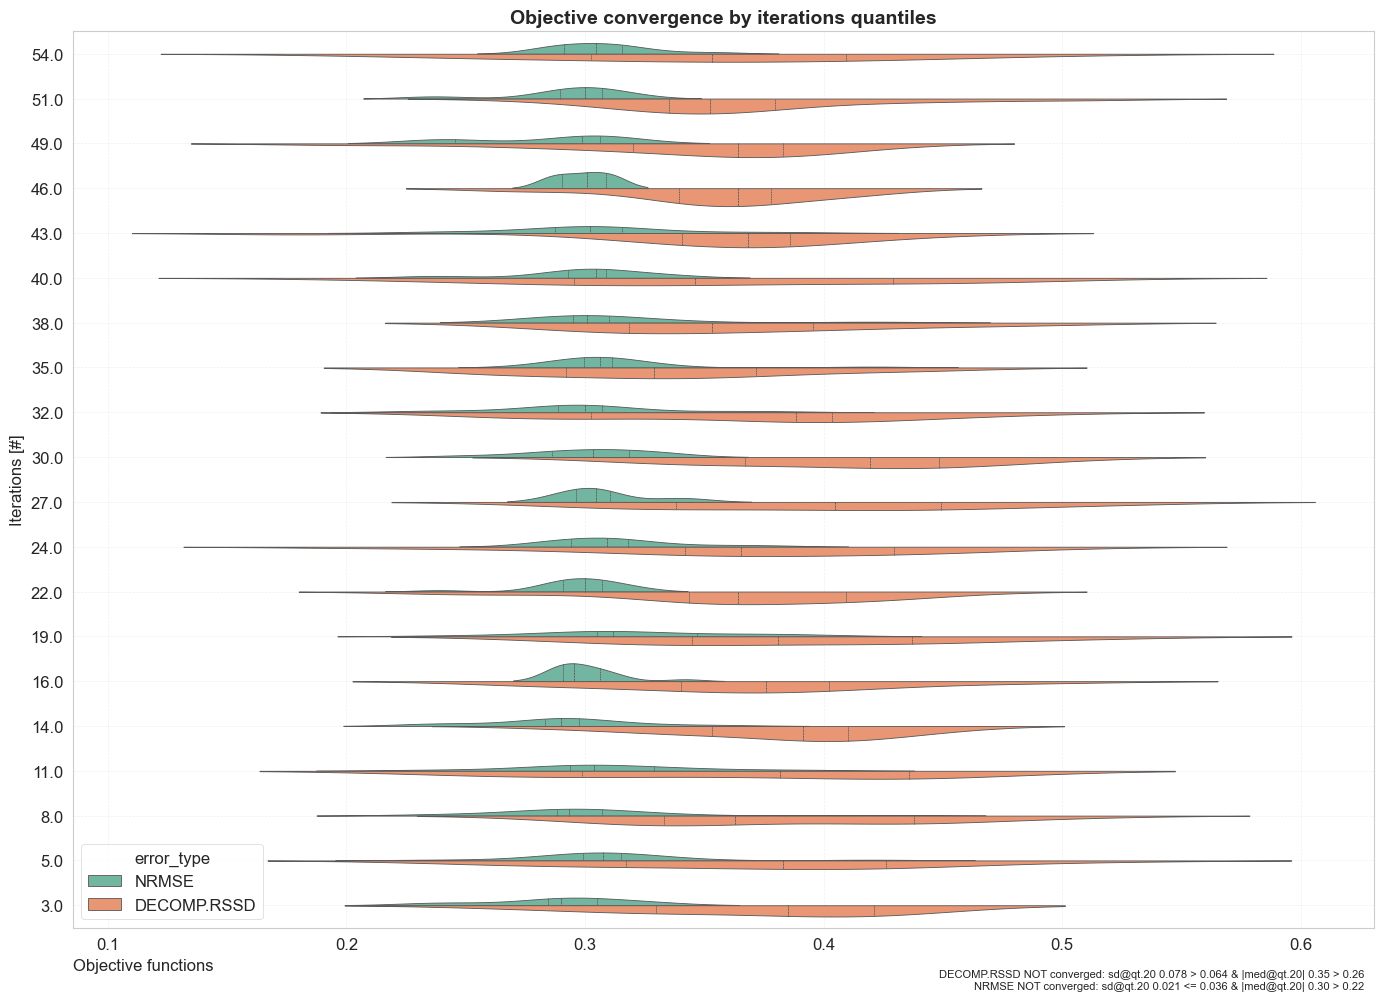

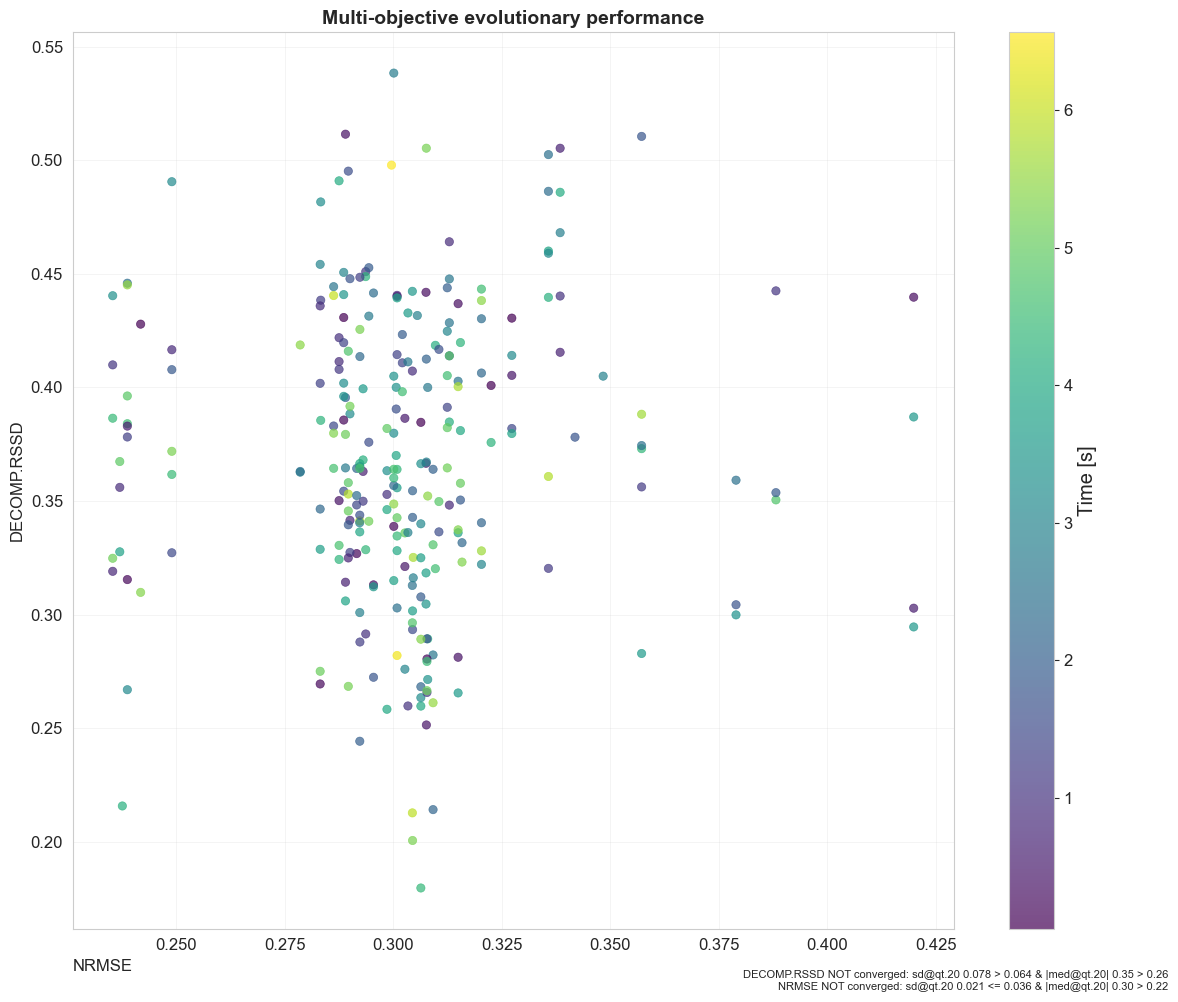

In [9]:
# Setup ModelExecutor
model_executor = ModelExecutor(
    mmmdata=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,  # Add calibration input if available
    featurized_mmm_data=featurized_mmm_data,
)

# Setup TrialsConfig
trials_config = TrialsConfig(
    iterations=54, trials=5
)  # Set to the number of cores you want to use

print(
    f">>> Starting {trials_config.trials} trials with {trials_config.iterations} iterations each using {NevergradAlgorithm.TWO_POINTS_DE.value} nevergrad algorithm on..."
)

# Run the model

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=True,  # changed from True to False -> deacitvate
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=8,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)
print("Model training complete.")

In [10]:
best_model_id = output_models.select_id
print(f"Best model ID: {best_model_id}")

Best model ID: 2_1_1


In [11]:
# Add after model training
print("Model Output Summary:")
print(f"Number of trials: {len(output_models.trials)}")
print(
    f"Average models per trial: {len(output_models.all_result_hyp_param) / len(output_models.trials)}"
)
print(
    f"Total unique models: {len(output_models.all_result_hyp_param['sol_id'].unique())}"
)

print("\nMetrics Distribution:")
metrics_df = output_models.all_result_hyp_param[["nrmse", "decomp.rssd", "mape"]]
print(metrics_df.describe())

# Additional validation to debug model output
print("\nColumns in result_hyp_param:")
print(output_models.all_result_hyp_param.columns.tolist())

print("\nSample rows of metrics:")
print(
    output_models.all_result_hyp_param[
        ["sol_id", "nrmse", "decomp.rssd", "mape"]
    ].head()
)

# Show shape of result dataframes
print("\nDataFrame Shapes:")
print(f"result_hyp_param: {output_models.all_result_hyp_param.shape}")
print(f"x_decomp_agg: {output_models.all_x_decomp_agg.shape}")
print(f"decomp_spend_dist: {output_models.all_decomp_spend_dist.shape}")

Model Output Summary:
Number of trials: 5
Average models per trial: 54.0
Total unique models: 270

Metrics Distribution:
            nrmse  decomp.rssd   mape
count  270.000000   270.000000  270.0
mean     0.302040     0.368954    0.0
std      0.030736     0.063796    0.0
min      0.235413     0.179811    0.0
25%      0.289696     0.327317    0.0
50%      0.300926     0.364911    0.0
75%      0.312495     0.414367    0.0
max      0.419955     0.538310    0.0

Columns in result_hyp_param:
['facebook_S_thetas', 'facebook_S_alphas', 'facebook_S_gammas', 'print_S_thetas', 'print_S_alphas', 'print_S_gammas', 'tv_S_thetas', 'tv_S_alphas', 'tv_S_gammas', 'search_S_thetas', 'search_S_alphas', 'search_S_gammas', 'ooh_S_thetas', 'ooh_S_alphas', 'ooh_S_gammas', 'newsletter_thetas', 'newsletter_alphas', 'newsletter_gammas', 'lambda', 'train_size', 'sol_id', 'Elapsed', 'ElapsedAccum', 'pos', 'trial', 'rsq_train', 'rsq_val', 'rsq_test', 'nrmse', 'nrmse_train', 'nrmse_val', 'nrmse_test', 'decomp.rssd

In [12]:
from robyn.modeling.pareto.pareto_optimizer import ParetoOptimizer
%load_ext autoreload
%autoreload 2

# 3. Create ParetoOptimizer instance
pareto_optimizer = ParetoOptimizer(
    mmm_data, output_models, hyperparameters, featurized_mmm_data, holidays_data
)

# 4. Run optimize function
pareto_result = pareto_optimizer.optimize(pareto_fronts="auto", min_candidates=100)

2024-11-21 02:18:58 [INFO] Starting Pareto optimization
2024-11-21 02:18:58 [INFO] Starting model data aggregation
2024-11-21 02:18:58 [INFO] Computing Pareto fronts
2024-11-21 02:18:58 [INFO] Pareto front computation completed
2024-11-21 02:18:58 [INFO] Preparing Pareto data
2024-11-21 02:18:58 [INFO] Number of Pareto-optimal solutions found: 222
2024-11-21 02:18:58 [INFO] Selected 10 Pareto-fronts containing 110 candidates
2024-11-21 02:18:58 [INFO] Filtering data for selected Pareto fronts...
2024-11-21 02:18:58 [INFO] Calculating response curves for 550 models' media variables...
Processing rows: 100%|██████████| 550/550 [00:06<00:00, 88.99it/s]
2024-11-21 02:19:05 [INFO] Successfully processed 550 response curves
2024-11-21 02:19:05 [INFO] Computing final metrics...
2024-11-21 02:19:05 [INFO] Calculating ROI and CPA metrics...
2024-11-21 02:19:05 [INFO] Starting plot data generation...
2024-11-21 02:19:05 [INFO] Processing Pareto front 1
2024-11-21 02:19:05 [INFO] Pareto-Front: 1 

## Clustering

In [13]:
from robyn.modeling.clustering.clustering_config import ClusteringConfig, ClusterBy
from robyn.modeling.clustering.cluster_builder import ClusterBuilder
from robyn.data.entities.enums import DependentVarType
import plotly.io as pio

pio.renderers.default = "iframe"

cluster_configs = ClusteringConfig(
    dep_var_type=DependentVarType(mmm_data.mmmdata_spec.dep_var_type),
    cluster_by=ClusterBy.HYPERPARAMETERS,
    max_clusters=10,
    min_clusters=3,
    weights=[1.0, 1.0, 1.0],
)

cluster_builder = ClusterBuilder(pareto_result=pareto_result)


cluster_results = cluster_builder.cluster_models(cluster_configs)

2024-11-21 02:19:16,212 - robyn.modeling.clustering.cluster_builder - INFO - Initializing ClusterBuilder
2024-11-21 02:19:16,212 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-11-21 02:19:16,213 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-11-21 02:19:16,213 - robyn.modeling.clustering.cluster_builder - INFO - ClusterBuilder initialization complete
2024-11-21 02:19:16,213 - robyn.modeling.clustering.cluster_builder - INFO - Starting model clustering process
2024-11-21 02:19:16,215 - robyn.modeling.clustering.cluster_builder - INFO - Clustering by: ClusterBy.HYPERPARAMETERS
2024-11-21 02:19:16,216 - robyn.modeling.clustering.cluster_builder - INFO - Starting optimal cluster selection
2024-11-21 02:19:16,216 - robyn.modeling.clustering.cluster_builder - INFO - Ignored features: nrmse_train, decomp.rssd, mape, nrmse, nrmse_test, sol_id, nrmse_val, pareto
2024-11-21 02:19:16,217 - robyn.modeling

In [14]:
# In your pareto result, look at
print("Pareto coefficients and decomposition:")
print(pareto_result.x_decomp_agg)

print("Cluster assignments:")
print(cluster_results)

Pareto coefficients and decomposition:
                      rn      coef  xDecompAgg  xDecompPerc  xDecompMeanNon0  \
0                     ds -0.009801    0.758583    -0.127842         0.008488   
1                  trend  0.006908    0.161888    -0.027283         0.006571   
2                 season  0.163994   -1.817894     0.306366         0.150996   
3                holiday  0.037599    0.109314    -0.018422         0.105715   
4     competitor_sales_B  0.161804   -1.912397     0.322292         0.140705   
...                  ...       ...         ...          ...              ...   
3235               ooh_S  0.018465    0.537162     0.678337         0.032481   
3236             print_S  0.046742    0.686056     0.866363         0.068393   
3237          facebook_S  0.076412    0.793459     1.001994         0.073375   
3238            search_S  0.046658   -2.218668    -2.801773         0.027530   
3239          newsletter  0.051747   -1.684442    -2.127143         0.039535   



## Allocator

## Run Different Optimization Scenarios

### Scenario 1: Default Max Response

In [19]:
from robyn.allocator.entities.allocation_params import AllocatorParams
from robyn.allocator.entities.allocation_result import (
    AllocationResult,
    OptimOutData,
    MainPoints,
)
from robyn.allocator.entities.optimization_result import OptimizationResult
from robyn.allocator.entities.constraints import Constraints
from robyn.allocator.optimizer import BudgetAllocator
from robyn.allocator.constants import (
    SCENARIO_MAX_RESPONSE,
    ALGO_SLSQP_AUGLAG,
    CONSTRAINT_MODE_EQ,
    DEFAULT_CONSTRAINT_MULTIPLIER,
    DATE_RANGE_ALL,
)

select_model = pareto_result.pareto_solutions[1]

# Create allocator parameters matching R Example 1
allocator_params = AllocatorParams(
    scenario=SCENARIO_MAX_RESPONSE,
    total_budget=None,  # When None, uses total spend in date_range
    target_value=None,
    date_range="all",
    channel_constr_low=[0.7],  # Single value for all channels
    channel_constr_up=[1.2, 1.5, 1.5, 1.5, 1.5],  # Different values per channel
    channel_constr_multiplier=3.0,
    optim_algo="SLSQP_AUGLAG",
    maxeval=100000,
    constr_mode=CONSTRAINT_MODE_EQ,
    plots=True,
)


print("\nInitial constraints:")
for channel, low, up in zip(
    mmm_data.mmmdata_spec.paid_media_spends,
    [0.7] * len(mmm_data.mmmdata_spec.paid_media_spends),  # Expand single value
    [1.2, 1.5, 1.5, 1.5, 1.5],  # Per channel values
):
    print(f"{channel}: {low:.1f}x - {up:.1f}x")

# Initialize budget allocator
max_response_allocator = BudgetAllocator(
    mmm_data=mmm_data,
    featurized_mmm_data=featurized_mmm_data,
    hyperparameters=hyperparameters,
    pareto_result=pareto_result,
    select_model=select_model,
    params=allocator_params,
)

## Step 3: Run Optimization
max_response_result = max_response_allocator.optimize()


Initial constraints:
tv_S: 0.7x - 1.2x
ooh_S: 0.7x - 1.5x
print_S: 0.7x - 1.5x
facebook_S: 0.7x - 1.5x
search_S: 0.7x - 1.5x
Model Coefficients:
             rn      coef  xDecompAgg  xDecompPerc  xDecompMeanNon0  \
846        tv_S  0.106114    1.030363    -0.603207         0.166094   
847       ooh_S  0.042240    1.490107    -0.872355         0.062354   
848     print_S  0.053800    0.687089    -0.402243         0.094119   
849  facebook_S  0.083750    0.213487    -0.124982         0.088741   
850    search_S  0.051240   -2.899624     1.697530         0.021655   

     xDecompMeanNon0Perc  xDecompAggRF  xDecompPercRF  xDecompMeanNon0RF  \
846             0.203693      1.030363      -0.603207           0.166094   
847             0.076469      1.490107      -0.872355           0.062354   
848             0.115424      0.687089      -0.402243           0.094119   
849             0.108829      0.213487      -0.124982           0.088741   
850             0.026557     -2.899624       1.

In [21]:
import numpy as np

## Step 4: Analyze Results
print("\nOptimization Results Summary:")
print("-" * 50)
print(f"Model ID: {select_model}")
print(f"Scenario: {max_response_result.scenario}")
print(f"Use case: {max_response_result.usecase}")

results_df = pd.DataFrame(
    {
        "Channel": max_response_result.dt_optimOut.channels,
        "Initial Spend": max_response_result.dt_optimOut.init_spend_unit,
        "Optimized Spend": max_response_result.dt_optimOut.optm_spend_unit,
        "Spend Change %": (
            max_response_result.dt_optimOut.optm_spend_unit
            / max_response_result.dt_optimOut.init_spend_unit
            - 1
        )
        * 100,
        "Initial Response": max_response_result.dt_optimOut.init_response_unit,
        "Optimized Response": max_response_result.dt_optimOut.optm_response_unit,
        "Response Lift %": (
            max_response_result.dt_optimOut.optm_response_unit
            / max_response_result.dt_optimOut.init_response_unit
            - 1
        )
        * 100,
    }
)

print("\nDetailed Results:")
print(results_df.round(2))

# Print additional diagnostics
print("\nOptimization Parameters:")
print(f"Total budget: {max_response_allocator.constraints.budget_constraint:,.2f}")
print("Bound multiplier:", max_response_allocator.params.channel_constr_multiplier)
print("\nConstraint Violations:")
violations = np.sum(
    np.abs(
        max_response_result.dt_optimOut.optm_spend_unit
        - max_response_allocator.init_spend_unit
    )
)
print(f"Total allocation adjustment: {violations:,.2f}")


Optimization Results Summary:
--------------------------------------------------
Model ID: 2_17_1
Scenario: max_response
Use case: all_historical_vec + historical_budget

Detailed Results:
      Channel  Initial Spend  Optimized Spend  Spend Change %  \
0        tv_S       16282.26         18988.38           16.62   
1       ooh_S       52818.55         44563.78          -15.63   
2     print_S        3856.63          5784.95           50.00   
3  facebook_S        2141.53          3212.29           50.00   
4    search_S        5099.15          7648.72           50.00   

   Initial Response  Optimized Response  Response Lift %  
0              0.00                0.00            55.06  
1              0.00                0.00           -21.97  
2              0.00                0.00           135.61  
3              0.00                0.00           156.63  
4              0.01                0.01            78.55  

Optimization Parameters:
Total budget: 80,198.11
Bound multiplie

2024-11-21 02:20:48,620 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-11-21 02:20:48,625 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-11-21 02:20:48,634 - robyn.visualization.allocator_visualizer - INFO - Initializing AllocatorPlotter
2024-11-21 02:20:48,661 - robyn.visualization.allocator_visualizer - INFO - Creating all plots for model 2_17_1
2024-11-21 02:20:48,664 - robyn.visualization.allocator_visualizer - INFO - Creating budget comparison plot


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2024-11-21 02:20:48,937 - robyn.visualization.allocator_visualizer - INFO - Creating allocation matrix plot
2024-11-21 02:20:49,183 - robyn.visualization.allocator_visualizer - INFO - Creating response curves plot


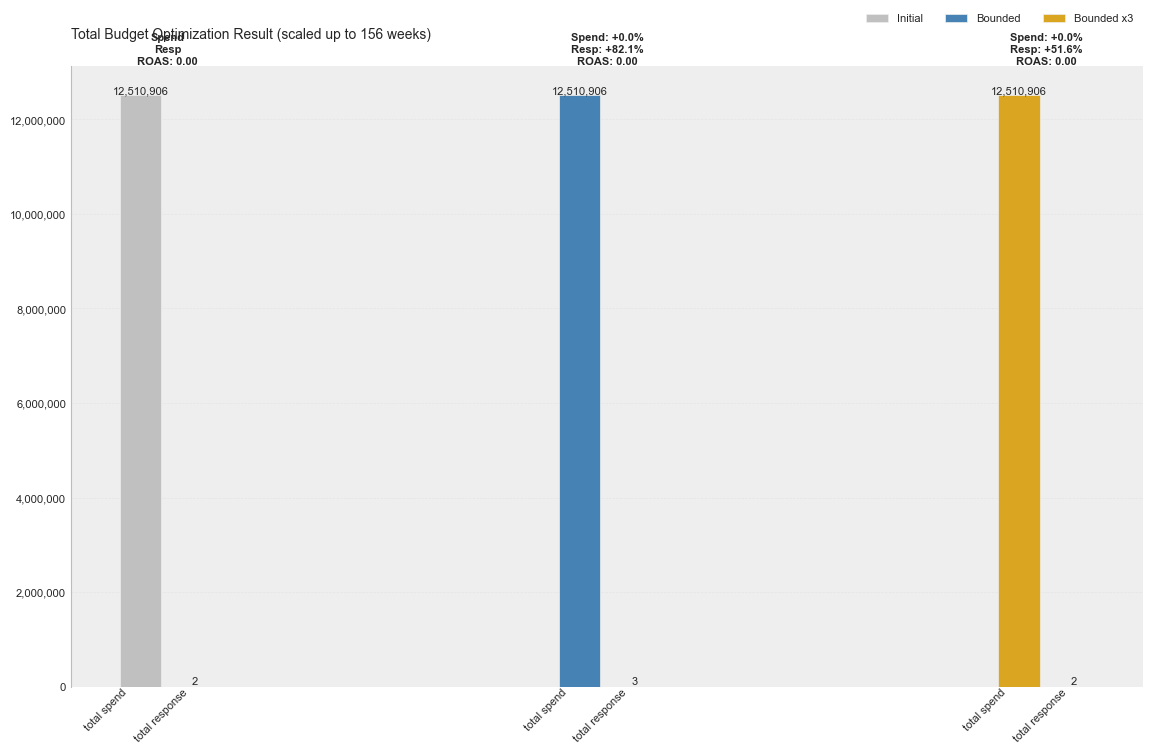

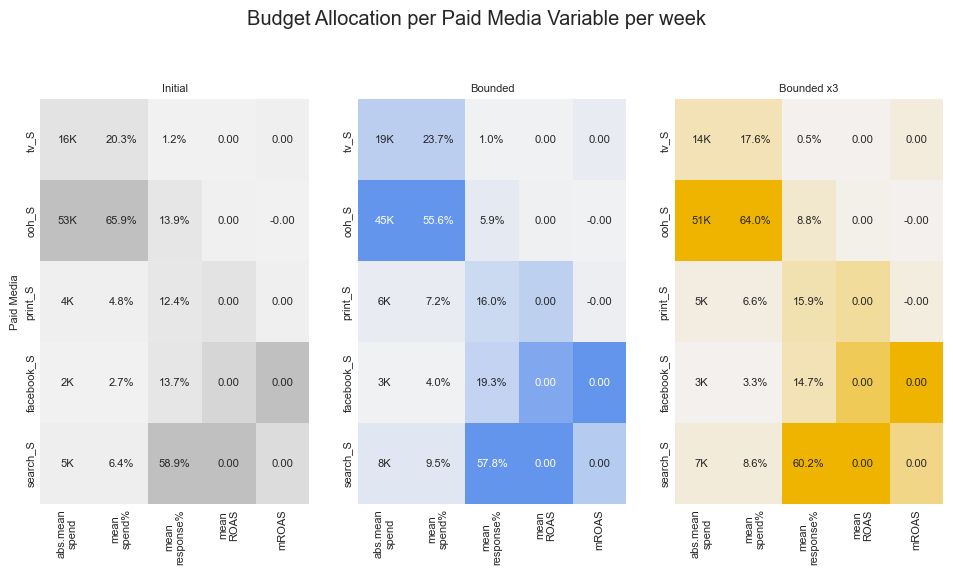

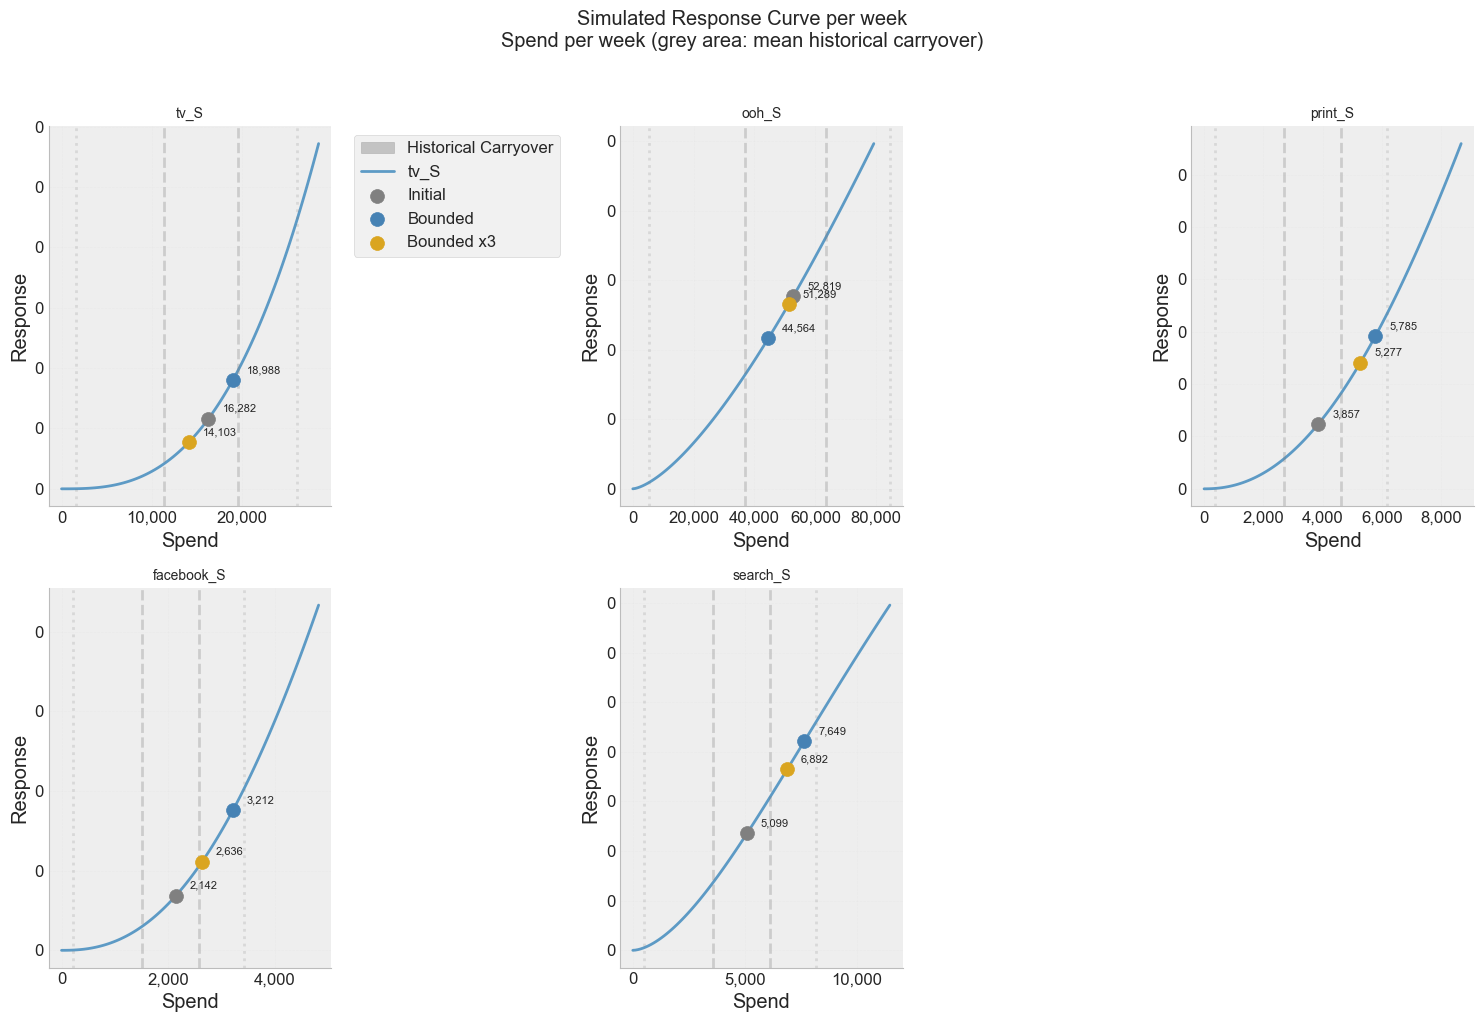

In [22]:
from robyn.visualization.allocator_visualizer import (
    AllocatorPlotter,
)
%load_ext autoreload
%autoreload 2
# Initialize plotter with just the essential data
plotter = AllocatorPlotter(
    allocation_result=max_response_result,
    budget_allocator=max_response_allocator
)

# Generate all plots
plots = plotter.plot_all(display_plots=False, export_location=None)